In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as mpl
import datetime
import os
from itertools import accumulate
from math import floor
from pandas.tseries.offsets import MonthEnd
import plotting 
from matplotlib.colors import LogNorm, Normalize
from  matplotlib import colormaps as cmaps 
import matplotlib.patches as mpatches
from matplotlib import colors
from os import path
import geopandas as gpd
import json
import re

In [2]:
_HOME_ = path.expanduser("~") + "/PHD"
import modify_dataset

In [3]:
phyto_abundances = pd.read_csv(_HOME_ + "/MSFD/Data/Modulo1/phyto_abund_modified.csv", index_col=0)
phyto_abundances.loc[:, "Date"] = pd.to_datetime(phyto_abundances["Date"])
with open(_HOME_ + "/ISPRA_20152017_Analysis/params.json") as file: 
    params = json.load(file)
best_path = params["best_path"]
best_path_sard = params["best_path_sard"]
ordered_regions = params["ordered_regions"]
seasons = params["seasons"]
sorted_season = params["sorted_season"]
sea_index = params["sea_index"]
ordered_id = params["ordered_id"]
sea_index_array = np.array(list(sea_index.values()))
del params
phyto_abund_simplified = modify_dataset.make_simplified_dataset(phyto_abundances, 0.7)
phyto_abund_simplified = modify_dataset.add_season_column(phyto_abund_simplified, seasons)
phyto_abund_simplified = modify_dataset.add_coast_dist_column(phyto_abund_simplified)
phyto_abund_simplified["Date"] = pd.to_datetime(phyto_abund_simplified["Date"]) + MonthEnd(0)
phyto_abund_simplified["Region"] = pd.Categorical(phyto_abund_simplified["Region"], categories = ordered_regions, ordered = True)
taxonomic_tree = pd.read_excel(_HOME_ + "/ISPRA_20152017_Analysis/Phyto_taxonomic_tree.xlsx")
taxonomic_tree.drop_duplicates(inplace=True)
phyto_abund_simplified = phyto_abund_simplified.merge(taxonomic_tree.loc[:,["ScientificName", "Genus", "Class"]], how = "left", left_on="Taxon", right_on="ScientificName")
phyto_abund_simplified["Class"] = phyto_abund_simplified["Class"].astype(str)
phyto_abund_simplified = modify_dataset.add_det_level_column(phyto_abund_simplified)
phyto_abund_simplified = phyto_abund_simplified.loc[:,
                                                    ["Region", "id", "Longitude", "Latitude", "Closest_coast", "Coast_dist", "Date", "Season_year", "Season", "Sample_depth", "Class", "Genus", "Det_level", "Taxon", "Num_cell_l", "file_name"]
                                                    ]
transects_info = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/transects_info.csv")
transects_info["Transect"] = transects_info["Transect"].str.upper()
phyto_abund_simplified = phyto_abund_simplified.merge(transects_info, how = "left", on = "id")

In [4]:
from_region_to_abreviation = {
    "Friuli-Venezia-Giulia" : "FVG",
    "Veneto" : "VEN", 
    "Emilia-Romagna" : "EMR",
    "Marche" : "MAR",
    "Abruzzo" : "ABR",
    "Molise" : "MOL",
    "Puglia" : "PUG",
    "Basilicata" : "BAS",
    "Calabria" : "CAL",
    "Campania" : "CAM", 
    "Lazio" : "LAZ",
    "Toscana" : "TOS",
    "Liguria" : "LIG",
     "Sicilia" : "SIC",
    "Sardegna" : "SAR"
}

In [5]:
phyto_abund_simplified["Region"] = phyto_abund_simplified["Region"].map(from_region_to_abreviation)

In [6]:
phyto_abund_simplified["Region"] = pd.Categorical(phyto_abund_simplified["Region"], categories = list(from_region_to_abreviation.values()), ordered = True)

In [7]:
phyto_abund_simplified.loc[phyto_abund_simplified["Taxon"] == 'Pseudo-nitzschia spp. del nitzschia delicatissima complex', "Taxon"] = 'Nitzschia delicatissima complex'
phyto_abund_simplified.loc[phyto_abund_simplified["Taxon"] == 'Pseudo-nitzschia spp. del nitzschia seriata complex', "Taxon"] = 'Nitzschia seriata complex'

In [8]:
stations_basins = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Stations_Basins.csv")

In [9]:
phyto_abund_simplified = phyto_abund_simplified.merge(stations_basins, how = "left", on = "id")

In [10]:
phyto_abund_simplified.loc[phyto_abund_simplified["Taxon"].str.contains("delicatissima"), "Taxon"].unique()

array(['Nitzschia delicatissima complex',
       'Pseudo-nitzschia delicatissima',
       'Pseudo-nitzschia pseudodelicatissima',
       'Pseudo-nitzschia delicatissima.'], dtype=object)

In [ ]:
italy = gpd.read_file(_HOME_ + "/ISPRA_20152017_Analysis/Description/Italy.shp")
surroundings = gpd.read_file(_HOME_ + "/ISPRA_20152017_Analysis/Description/Surrounding.shp")
basins = gpd.read_file(_HOME_ + "/ISPRA_20152017_Analysis/Description/Basins.shp") 

(36.0, 47.0)

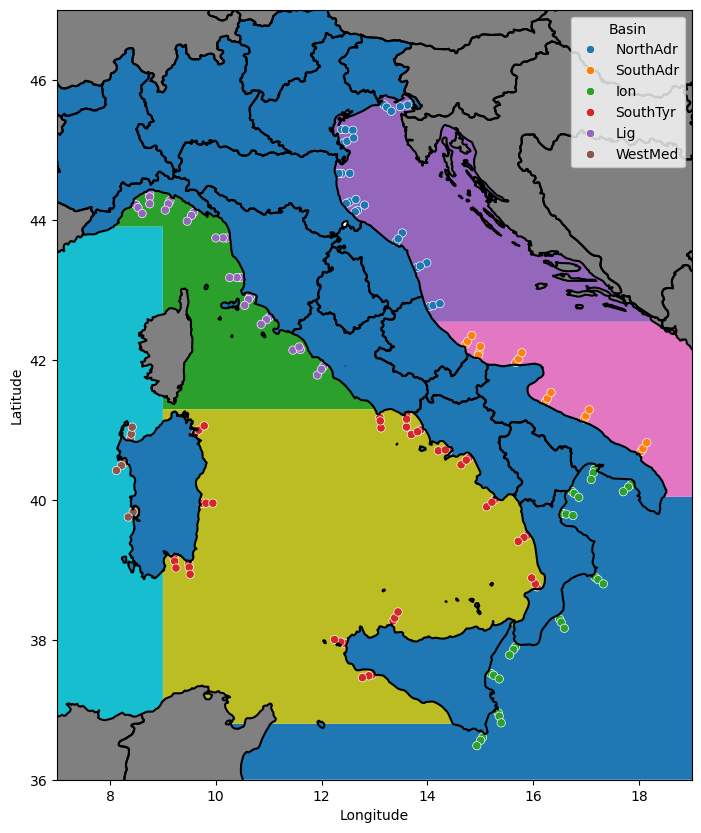

In [57]:
fig, ax = plt.subplots(figsize=(10, 10))

italy.boundary.plot(ax=ax, color='black')
surroundings.plot(ax = ax, color = "grey")
surroundings.boundary.plot(ax = ax, color = "black")
italy.plot(ax = ax)
basins.plot("Basin",ax = ax)
sns.scatterplot(data = phyto_abund_simplified.loc[:, ["Longitude", "Latitude", "Basin"]].drop_duplicates(), x = "Longitude", y = "Latitude", ax = ax, hue = "Basin")
ax.set_xlim(7,19)
ax.set_ylim(36,47)

# First part

In [12]:
phyto_abund_simplified.query("Taxon != 'Other phytoplankton' and Det_level == 'Species'")[["Class", "Taxon"]].groupby("Class").nunique().sort_values("Taxon", ascending = False).to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/phyto_classes.csv")

In [13]:
phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby("Taxon").count()["Num_cell_l"].quantile(np.arange(0, 1.05, 0.05))

0.00       1.00
0.05       1.00
0.10       1.00
0.15       1.00
0.20       2.00
0.25       3.00
0.30       4.00
0.35       5.00
0.40       7.00
0.45       8.25
0.50      12.00
0.55      16.00
0.60      22.00
0.65      30.00
0.70      44.00
0.75      63.00
0.80      90.00
0.85     131.25
0.90     216.50
0.95     416.50
1.00    1380.00
Name: Num_cell_l, dtype: float64

In [153]:
phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby("Taxon").count()[["Num_cell_l"]].query("Num_cell_l >416 ").sort_values(ascending=False, by = "Num_cell_l").to_csv(
    _HOME_ + "/ISPRA_20152017_Analysis/Description/Taxa_freq_95.csv")

In [58]:
freq_taxa = phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby("Taxon").count()[["Num_cell_l"]].query("Num_cell_l >= 416 ").sort_values(ascending=False, by = "Num_cell_l").index

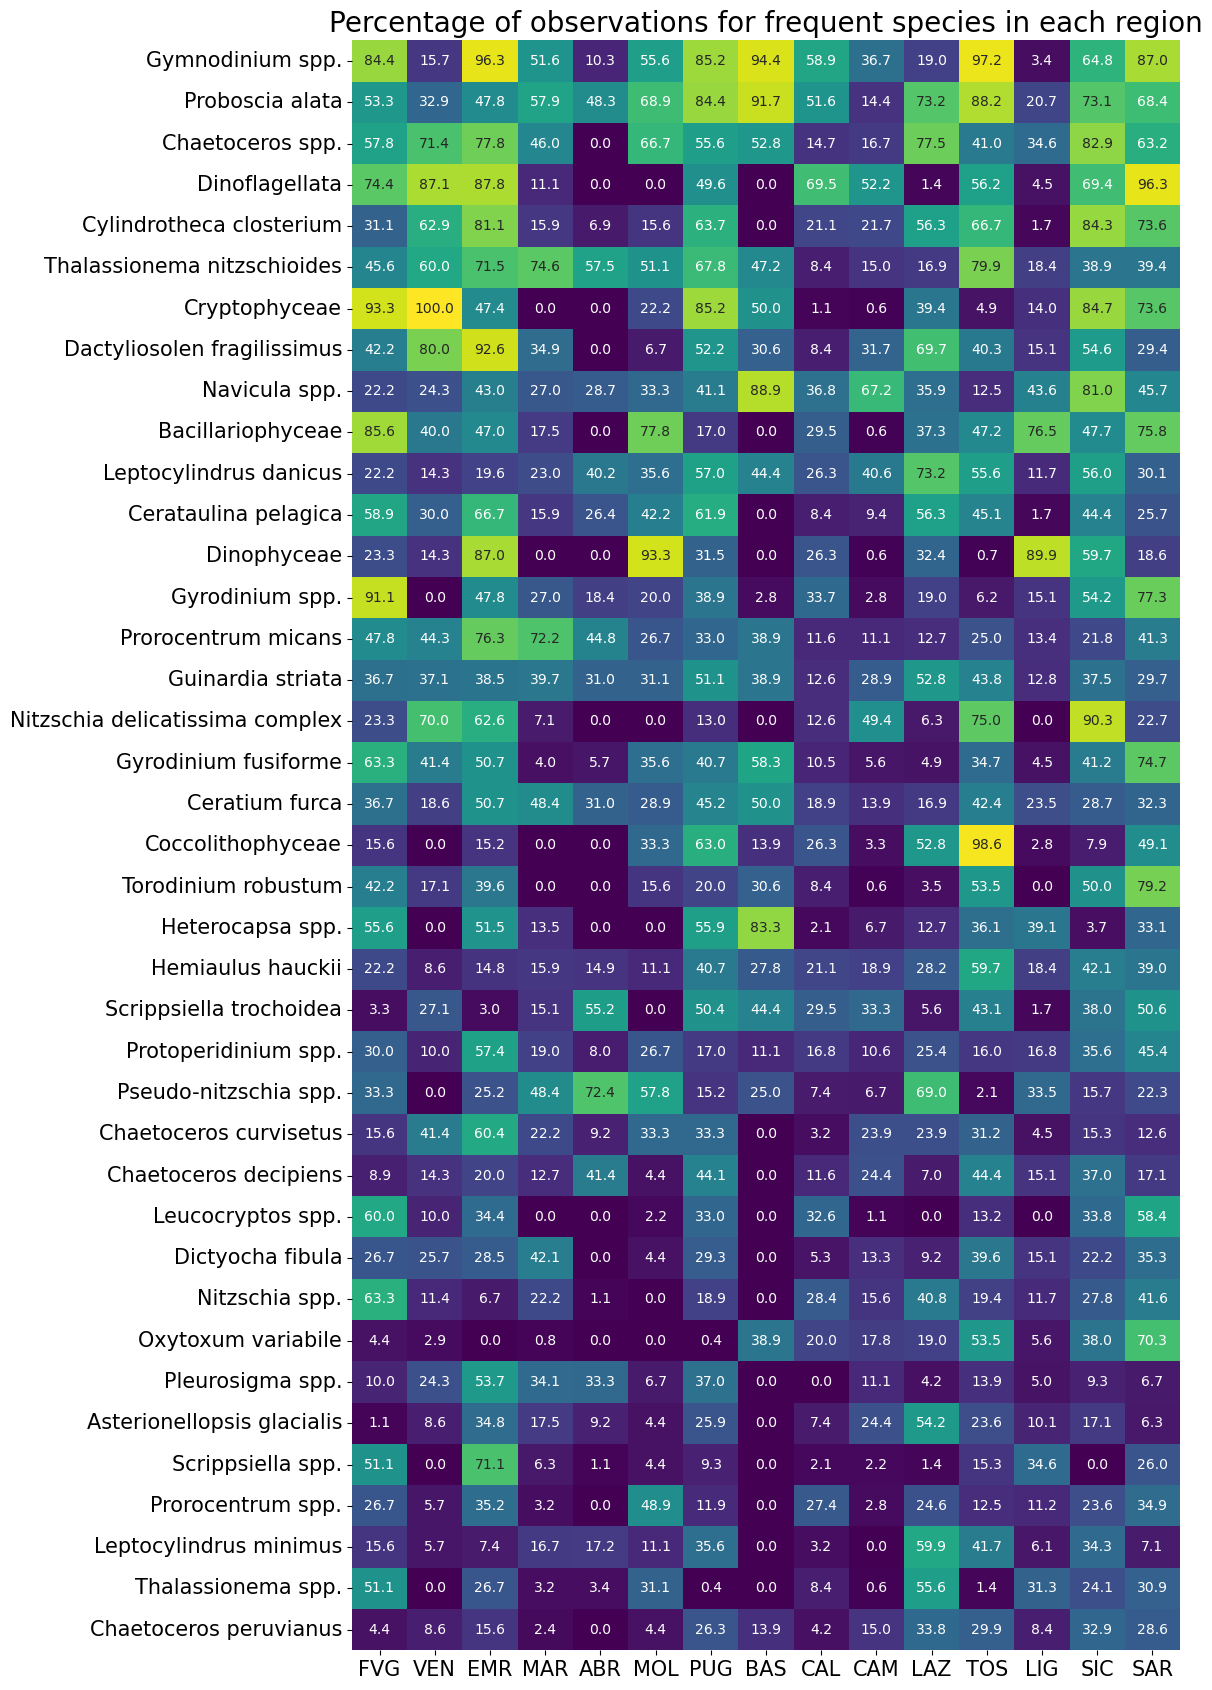

In [187]:
pres_abs = phyto_abund_simplified.query("Taxon in @freq_taxa").pivot_table(
    index= ["Region", "Date", "id"], 
    columns="Taxon",
    values="Num_cell_l",
    aggfunc="mean",
    fill_value=0
) > 0
pres_abs.reset_index(inplace=True)
n_region_samples = pres_abs.drop_duplicates(["Date", "id"]).groupby("Region", observed=True).count()["id"].to_numpy()
fig, ax = plt.subplots(figsize=(12, 17))

sns.heatmap(
data = pres_abs.groupby("Region", observed=True).sum(numeric_only=True).apply(lambda x: x / n_region_samples, axis=0).T.loc[freq_taxa, :] * 100, 
cmap = "viridis",
annot=True,
fmt=".1f",
ax = ax, 
cbar=False
)
ax.set_yticks(ax.get_yticks());
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, size = 15);
ax.set_xticks(ax.get_xticks());
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15);
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Percentage of observations for frequent species in each region", fontsize = 20)
plt.tight_layout()
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_freq_95_heatmap.png", dpi = 300, bbox_inches = "tight")

/tmp/ipykernel_14543/3907301209.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pres_abs = phyto_abund_simplified.query("Taxon in @freq_taxa").pivot_table(


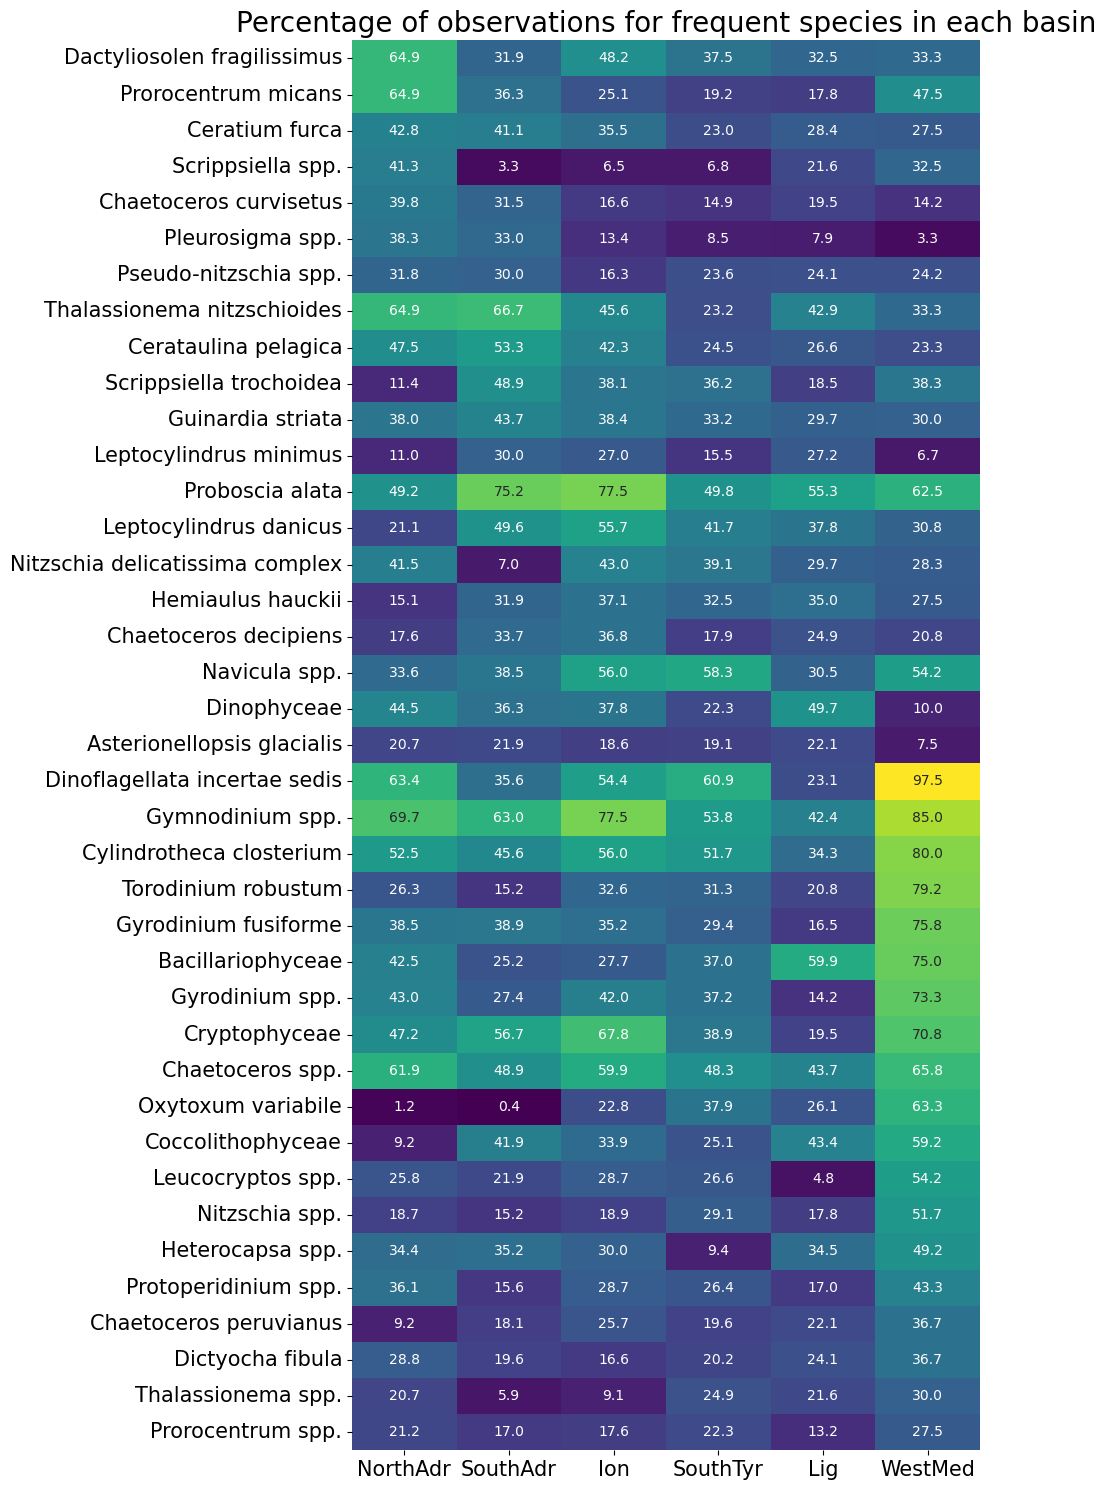

In [87]:
pres_abs = phyto_abund_simplified.query("Taxon in @freq_taxa").pivot_table(
    index= ["Basin", "Date", "id"], 
    columns="Taxon",
    values="Num_cell_l",
    aggfunc="mean",
    fill_value=0
) > 0
pres_abs.reset_index(inplace=True)
n_Basin_samples = pres_abs.drop_duplicates(["Date", "id"]).groupby("Basin", observed=True).count()["id"].to_numpy()
pres_abs = pres_abs.groupby("Basin", observed=True).sum(numeric_only=True).apply(lambda x: x / n_Basin_samples, axis=0).T.loc[freq_taxa, :] * 100
pres_abs_long = pres_abs.reset_index().melt(id_vars = "Taxon", var_name = "Basin", value_name = "Freq")
pres_abs_long["Basin"] = pd.Categorical(pres_abs_long["Basin"], categories = ["NorthAdr", "SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed"], ordered = True)
idx = pres_abs_long.groupby("Taxon")["Freq"].idxmax()
ordered_ids = pres_abs_long.loc[idx].sort_values(["Basin", "Freq"], ascending=[True, False])["Taxon"]


fig, ax = plt.subplots(figsize=(10, 15))
sns.heatmap(
data = pres_abs.loc[ordered_ids, :], 
cmap = "viridis",
annot=True,
fmt=".1f",
ax = ax, 
cbar=False
)
ax.set_yticks(ax.get_yticks());
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, size = 15);
ax.set_xticks(ax.get_xticks());
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15);
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Percentage of observations for frequent species in each basin", fontsize = 20)
plt.tight_layout()
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_freq_95_heatmap_per_basin.png", dpi = 300, bbox_inches = "tight")

In [74]:
data = phyto_abund_simplified.groupby("Taxon").sum(numeric_only=True).sort_values("Num_cell_l", ascending = False)
data["Percent_cumsum"] = data["Num_cell_l"].cumsum() / data["Num_cell_l"].sum()
data["Percen_abund"] = data["Num_cell_l"] / data["Num_cell_l"].sum() * 100

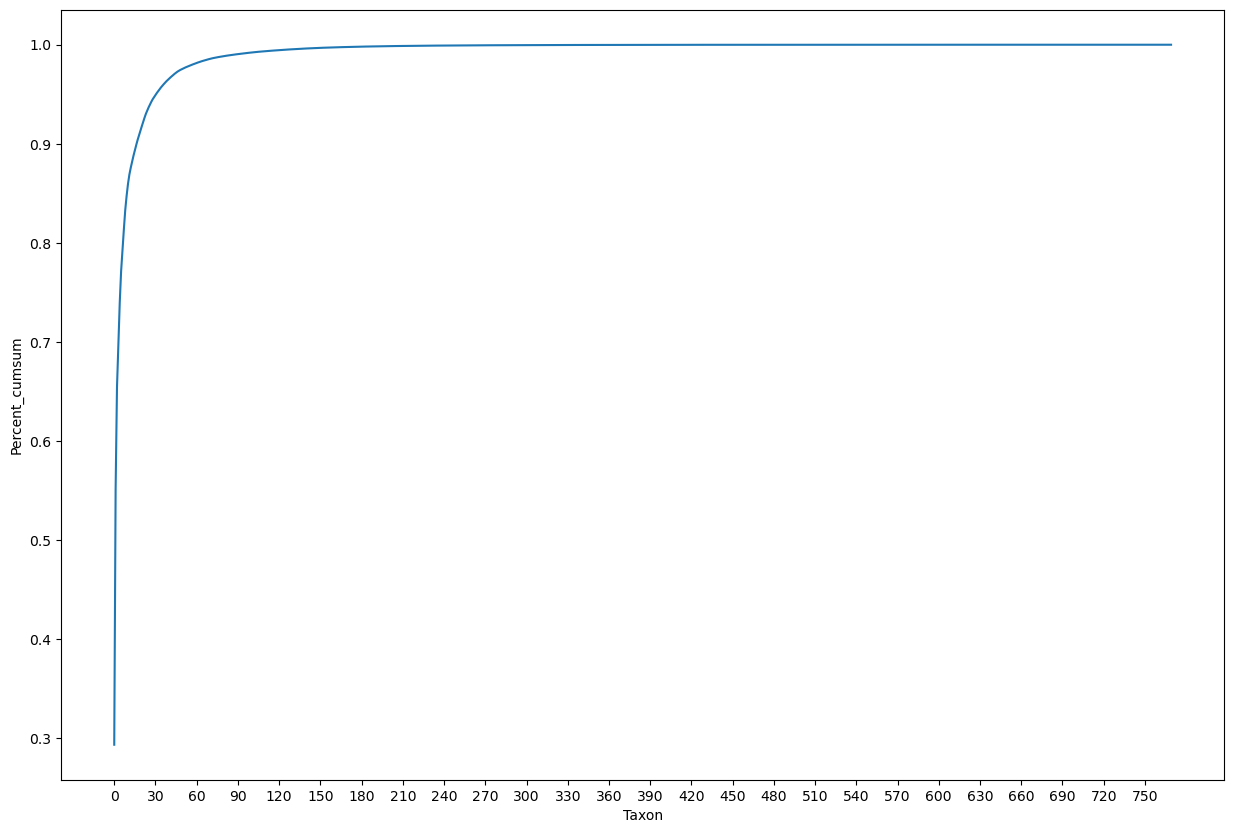

In [29]:
fig, ax = plt.subplots(figsize=(15, 10))

#.query("Taxon != 'Other phytoplankton'")

sns.lineplot(
    x = "Taxon",
    y = "Percent_cumsum",
    data = data,
    ax = ax
)
ax.set_xticks(np.arange(0, len(data), 30));
ax.set_xticklabels(np.arange(0, len(data), 30));

In [75]:
abund_taxa = data.query("Percent_cumsum <= 0.95")["Percen_abund"].index

In [66]:
data.query("Percent_cumsum <= 0.95")["Percen_abund"].to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_abund_95.csv")

In [159]:
rel_taxa = set(freq_taxa).union(set(abund_taxa))

In [172]:
phyto_abund_simplified.groupby("Region", observed=True).nunique()[["Taxon"]]

Taxon
Region       
FVG       221
VEN       146
EMR       290
MAR       227
ABR       107
MOL       113
PUG       378
BAS        75
CAL       209
CAM       169
LAZ       216
TOS       389
LIG       215
SIC       249
SAR       445

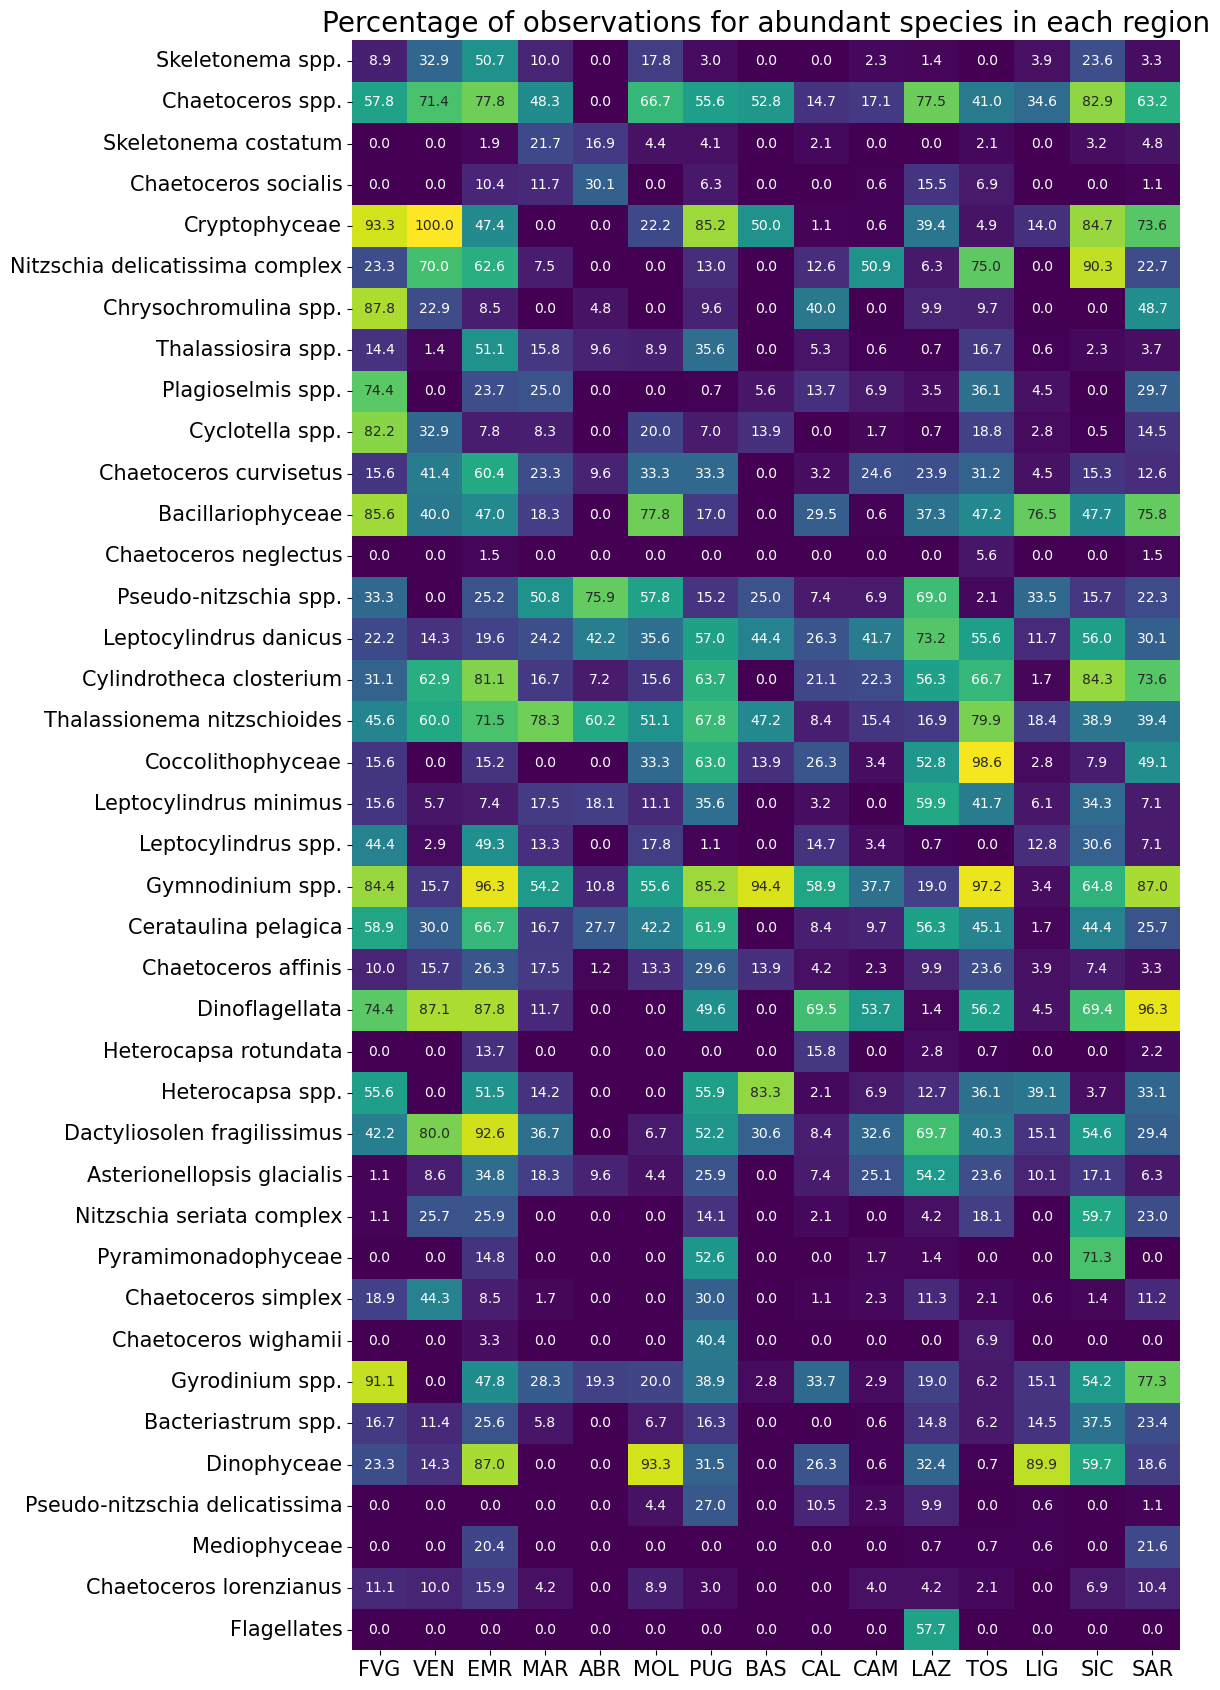

In [190]:
pres_abs = phyto_abund_simplified.query("Taxon in @abund_taxa").pivot_table(
    index= ["Region", "Date", "id"], 
    columns="Taxon",
    values="Num_cell_l",
    aggfunc="mean",
    fill_value=0
) > 0
pres_abs.reset_index(inplace=True)
n_region_samples = pres_abs.drop_duplicates(["Date", "id"]).groupby("Region", observed=True).count()["id"].to_numpy()

fig, ax = plt.subplots(figsize=(12, 17))

sns.heatmap(
data = pres_abs.groupby("Region", observed=True).sum(numeric_only=True).apply(lambda x: x / n_region_samples, axis=0).T.loc[abund_taxa, :] * 100, 
cmap = "viridis",
annot=True,
fmt=".1f",
ax = ax, 
cbar=False
)
ax.set_yticks(ax.get_yticks());
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, size = 15);
ax.set_xticks(ax.get_xticks());
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15);
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Percentage of observations for abundant species in each region", fontsize = 20)
plt.tight_layout()
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_abund_95_heatmap.png", dpi = 300, bbox_inches = "tight")

/tmp/ipykernel_14543/67642050.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pres_abs = phyto_abund_simplified.query("Taxon in @abund_taxa").pivot_table(


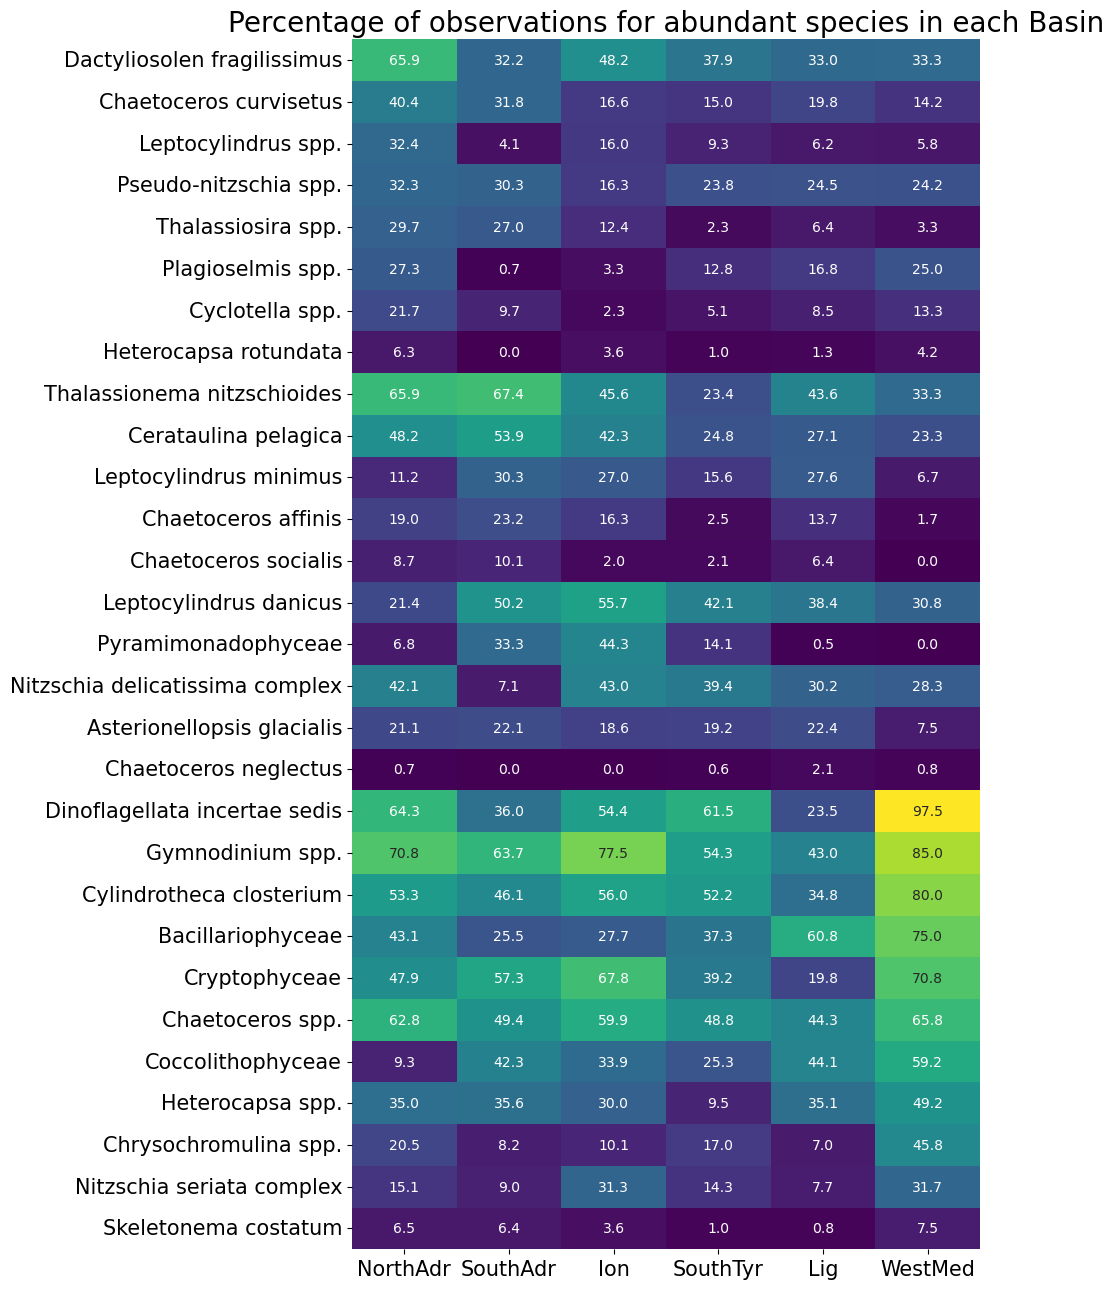

In [88]:
pres_abs = phyto_abund_simplified.query("Taxon in @abund_taxa").pivot_table(
    index= ["Basin", "Date", "id"], 
    columns="Taxon",
    values="Num_cell_l",
    aggfunc="mean",
    fill_value=0
) > 0
pres_abs.reset_index(inplace=True)
n_Basin_samples = pres_abs.drop_duplicates(["Date", "id"]).groupby("Basin", observed=True).count()["id"].to_numpy()
pres_abs = pres_abs.groupby("Basin", observed=True).sum(numeric_only=True).apply(lambda x: x / n_Basin_samples, axis=0).T.loc[abund_taxa[1:], :] * 100
pres_abs_long = pres_abs.reset_index().melt(id_vars = "Taxon", var_name = "Basin", value_name = "Freq")
pres_abs_long["Basin"] = pd.Categorical(pres_abs_long["Basin"], categories = ["NorthAdr", "SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed"], ordered = True)
idx = pres_abs_long.groupby("Taxon")["Freq"].idxmax()
ordered_ids = pres_abs_long.loc[idx].sort_values(["Basin", "Freq"], ascending=[True, False])["Taxon"]


fig, ax = plt.subplots(figsize=(10, 13))

sns.heatmap(
data = pres_abs.loc[ordered_ids, :], 
cmap = "viridis",
annot=True,
fmt=".1f",
ax = ax, 
cbar=False
)
ax.set_yticks(ax.get_yticks());
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, size = 15);
ax.set_xticks(ax.get_xticks());
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15);
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Percentage of observations for abundant species in each Basin", fontsize = 20)
plt.tight_layout()
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_abund_95_heatmap_per_basin.png", dpi = 300, bbox_inches = "tight")

In [315]:
phyto_abund_simplified.loc[:, ["id", "Basin"]].drop_duplicates().to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Station_basin.csv", index=False)

In [317]:
indval = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/indval_per_basin.csv", )

In [321]:
import re
indval.iloc[:, 0] = indval.iloc[:, 0].apply(lambda x: re.sub(r'\.(?!$)', ' ', x))

In [324]:
np.sort(abund_taxa.intersection(set(indval.iloc[:, 0])))

array(['Bacillariophyceae', 'Cerataulina pelagica',
       'Chaetoceros curvisetus', 'Chaetoceros spp.', 'Coccolithophyceae',
       'Cylindrotheca closterium', 'Dactyliosolen fragilissimus',
       'Gymnodinium spp.', 'Gyrodinium spp.', 'Leptocylindrus spp.',
       'Skeletonema spp.', 'Thalassionema nitzschioides',
       'Thalassiosira spp.'], dtype=object)

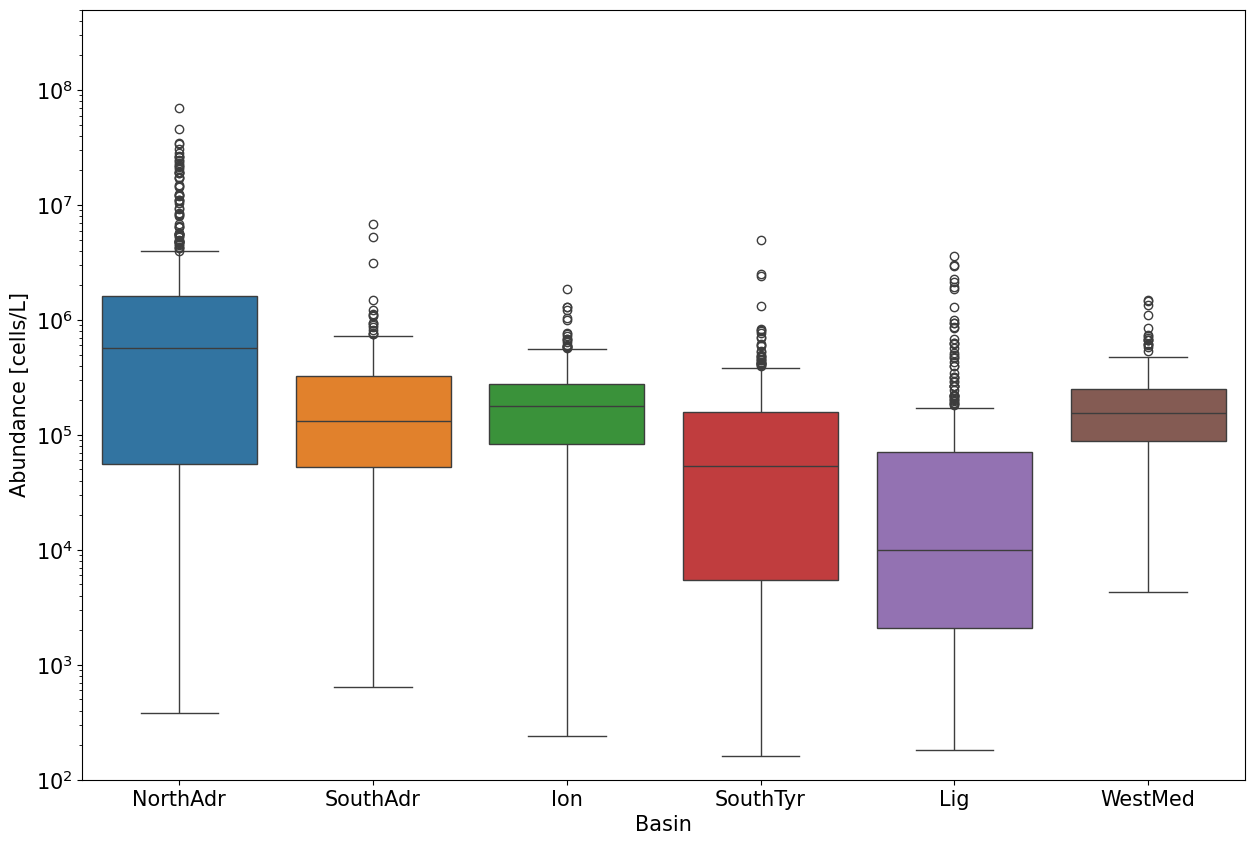

In [89]:
fig, ax = plt.subplots(figsize=(15, 10))

abund = phyto_abund_simplified.groupby(["Date", "id"]).agg(
    {"Num_cell_l" : "sum", 
     "Basin" : "first",
     }
)

sns.boxplot(
    x = "Basin",
    y = "Num_cell_l",
    data = abund,
    hue = "Basin",
    ax = ax
)
ax.set_yscale("log")
ax.set_ylabel("Abundance [cells/L]", size = 15)
ax.set_xlabel("Basin", size = 15)
ax.set_xticks(ax.get_xticks());
ax.set_xticklabels(ax.get_xticklabels(), size = 15);
ax.set_yticks(ax.get_yticks());
ax.set_yticklabels(ax.get_yticklabels(), size = 15);
ax.set_ylim(1e2, 5 * 1e8)
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/Abundance_per_basin.png", dpi = 300, bbox_inches = "tight")

In [55]:
"Heterocapsa niei" in phyto_abund_simplified["Taxon"].to_list()

True

In [63]:
phyto_abund_simplified.loc[phyto_abund_simplified["Taxon"].str.contains("hydroideus"), "Taxon"].unique()

array(['Ophiaster hydroideus'], dtype=object)

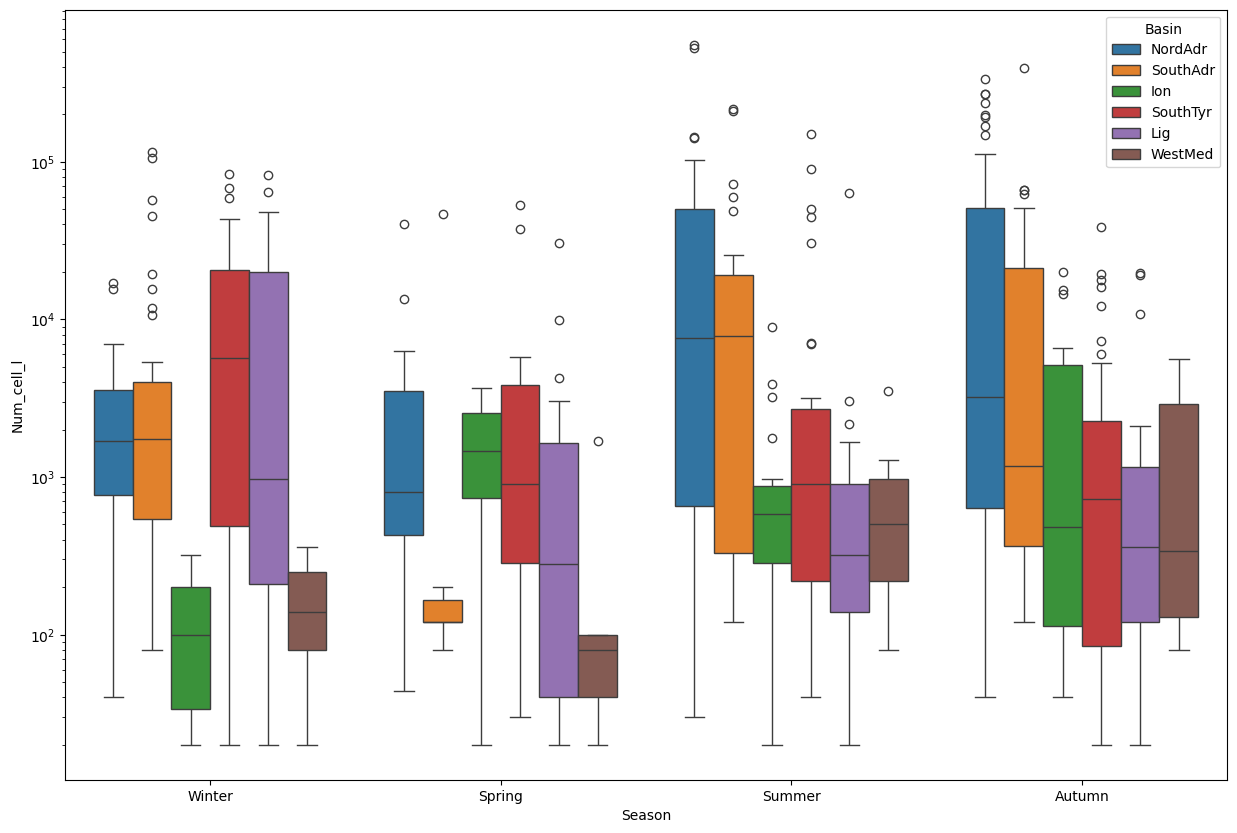

In [71]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.boxplot(
    data = phyto_abund_simplified.query("Taxon == 'Pseudo-nitzschia spp.'"), 
    x = "Season",
    y = "Num_cell_l", 
    hue = "Basin"
)
ax.set_yscale("log")

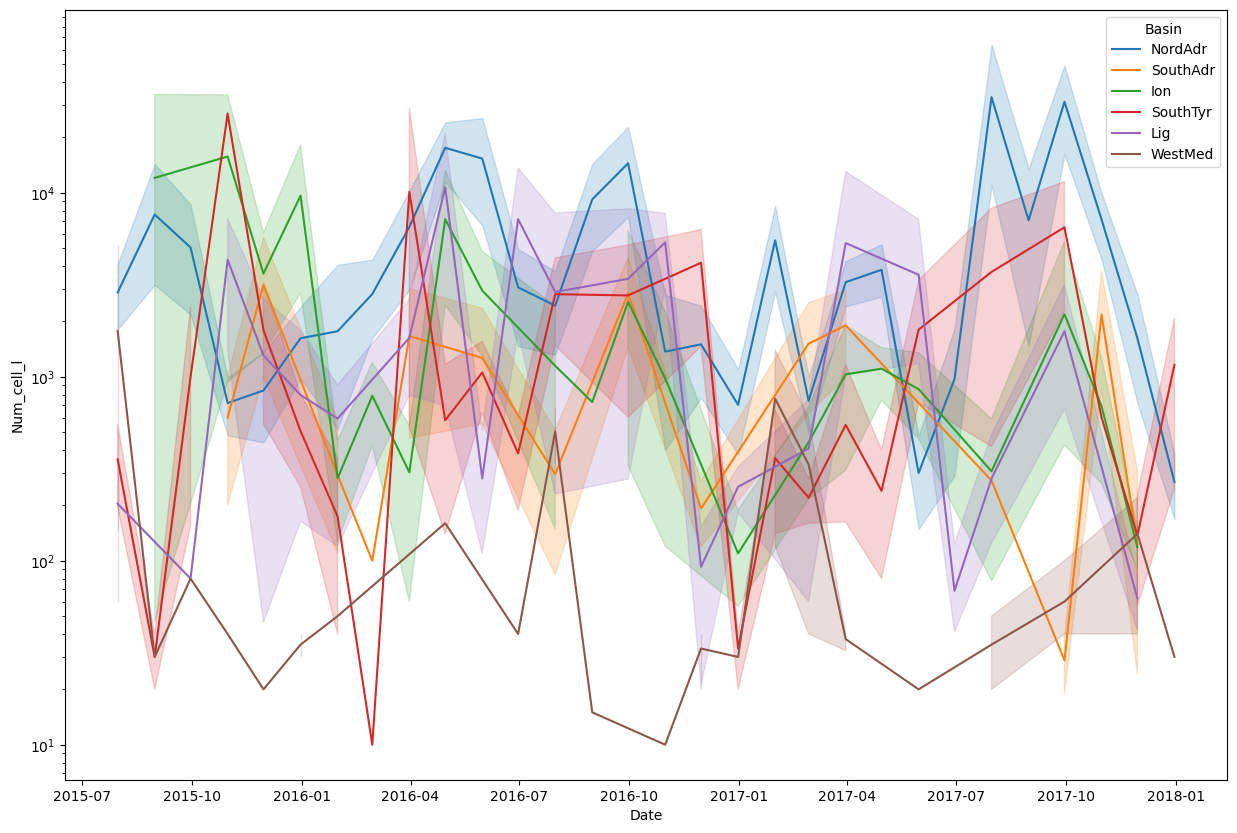

In [53]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.lineplot(
    data = phyto_abund_simplified.query("Taxon == 'Dactyliosolen fragilissimus'"), 
    x = "Date",
    y = "Num_cell_l", 
    hue = "Basin"
)
ax.set_yscale("log")

# Second Part

In [17]:
phyto_abund_simplified.query("Det_level == 'Species'").groupby("Taxon").count().sort_values("Region")["Region"].quantile(0.95)

331.55000000000007

In [22]:
phyto_abund_simplified.query("Det_level == 'Species'").groupby("Taxon").count()[["Region"]].sort_values("Region", ascending = False).query("Region > 332").to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_freq_top.csv")

In [27]:
phyto_abund_simplified.drop_duplicates(["Date", "id", "Genus"]).groupby("Genus").count()[["Region"]].quantile(0.95)

Region    1052.8
Name: 0.95, dtype: float64

In [28]:
phyto_abund_simplified.drop_duplicates(["Date", "id", "Genus"]).groupby("Genus").count()[["Region"]].sort_values("Region", ascending = False).query("Region > 1052").to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Genera_freq_top.csv")

In [29]:
phyto_abund_simplified["Det_level"].unique()

array(['Species', 'Genus', 'Higher cat.', 'Unknown'], dtype=object)

In [31]:
phyto_abund_simplified.drop_duplicates(["Date", "id", "Class"]).groupby("Class").count()[["Region"]].quantile(0.95)

Region    1945.6
Name: 0.95, dtype: float64

In [34]:
phyto_abund_simplified.drop_duplicates(["Date", "id", "Class"]).groupby("Class").count()[["Region"]].sort_values("Region", ascending = False).iloc[:12].to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Classes_freq_top.csv")

In [77]:
abund_taxa = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_abund_95.csv").query("Taxon != 'Other phytoplankton'")["Taxon"].to_list()

In [78]:
abund_per_basin = phyto_abund_simplified.groupby(
    "Basin", observed=True
).sum(numeric_only=True)[["Num_cell_l"]]

/tmp/ipykernel_14543/2230839508.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  abund_distribution = phyto_abund_simplified.query("Taxon in @abund_taxa").groupby(["Taxon", "Basin"], observed=True).sum(numeric_only=True)[["Num_cell_l"]].pivot_table(index="Taxon", columns="Basin", values="Num_cell_l", fill_value=0).loc[abund_taxa,:] / abund_per_basin.T.to_numpy() * 100


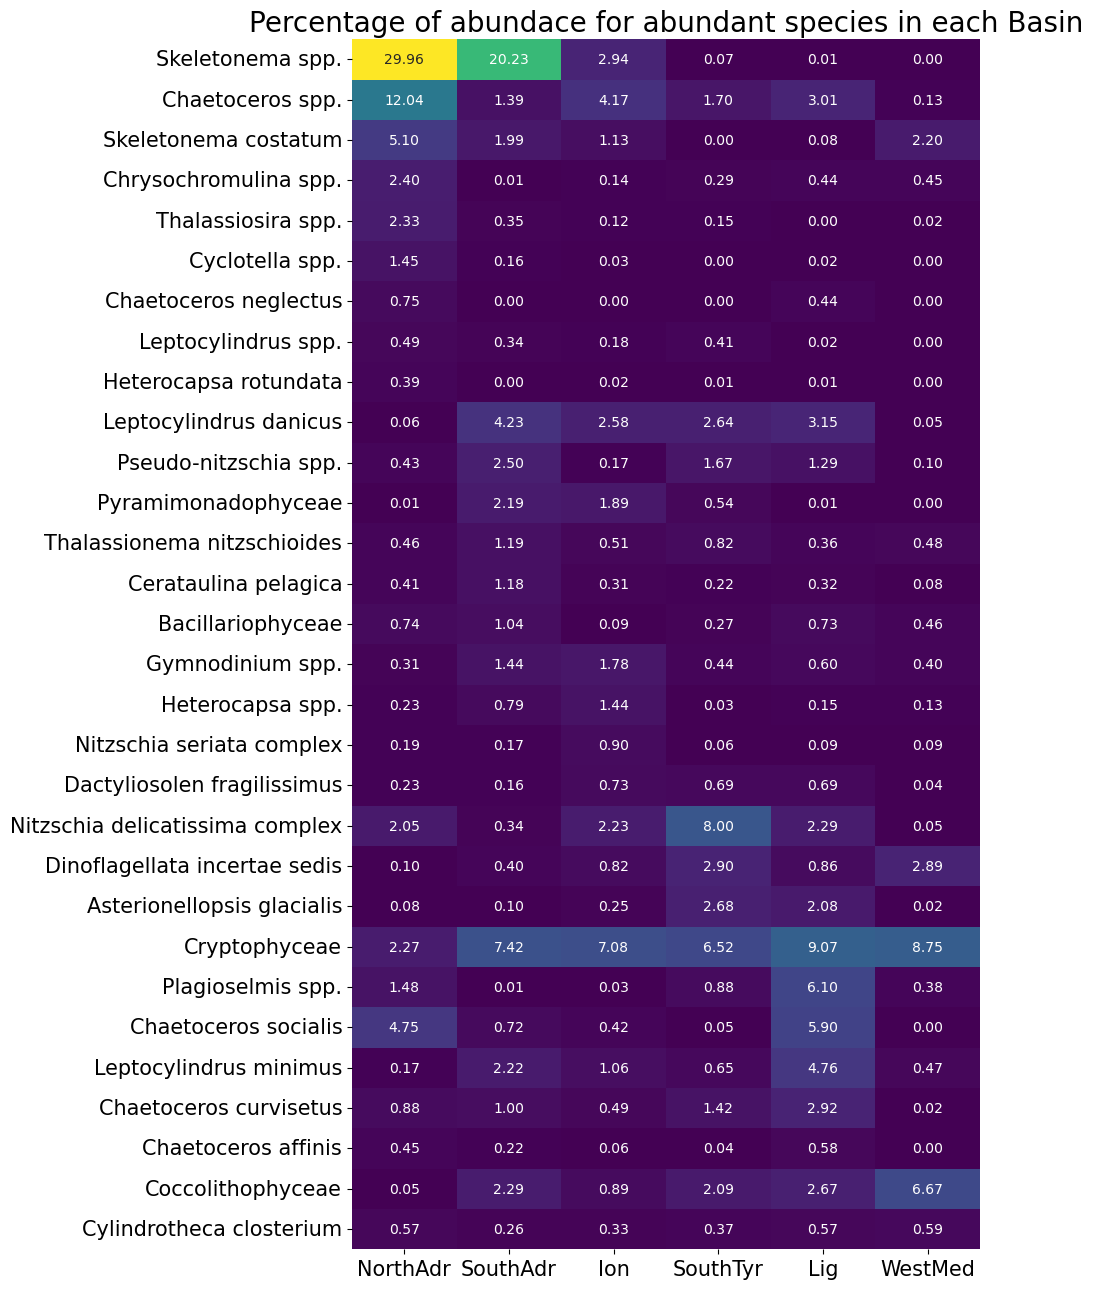

In [90]:
abund_distribution = phyto_abund_simplified.query("Taxon in @abund_taxa").groupby(["Taxon", "Basin"], observed=True).sum(numeric_only=True)[["Num_cell_l"]].pivot_table(index="Taxon", columns="Basin", values="Num_cell_l", fill_value=0).loc[abund_taxa,:] / abund_per_basin.T.to_numpy() * 100
abund_distribution_long = abund_distribution.reset_index().melt(id_vars="Taxon", var_name="Basin", value_name="Freq")
abund_distribution_long["Basin"] = pd.Categorical(abund_distribution_long["Basin"], categories=["NorthAdr", "SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed"], ordered=True)
idx = abund_distribution_long.groupby("Taxon")["Freq"].idxmax()
ordered_ids = abund_distribution_long.loc[idx].sort_values(["Basin", "Freq"], ascending=[True, False])["Taxon"]

fig, ax = plt.subplots(figsize=(10, 13))

sns.heatmap(
data = abund_distribution.loc[ordered_ids, :], 
cmap = "viridis",
annot=True,
fmt=".2f",
ax = ax, 
cbar=False
)
ax.set_yticks(ax.get_yticks());
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, size = 15);
ax.set_xticks(ax.get_xticks());
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15);
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Percentage of abundace for abundant species in each Basin", fontsize = 20)
plt.tight_layout()
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_abund_distribution_heatmap_per_basin.png", dpi = 300, bbox_inches = "tight")

In [16]:
def order_species(df, basins, threshold = 0.5): 
    
    characteristic_species = df.index[np.where(df.loc[:, basins].max(axis = 1) >= threshold)]
    df_long = df.loc[characteristic_species, basins].reset_index().melt(id_vars="Taxon", var_name="Basin", value_name="Value")
    df_long["Basin"] = pd.Categorical(df_long["Basin"], categories=basins, ordered=True)
    idx = df_long.groupby("Taxon")["Value"].idxmax()
    ordered_ids = df_long.loc[idx].sort_values(["Basin", "Value"], ascending=[True, False])["Taxon"]
    return ordered_ids

In [19]:
def indval_plot(df, title = "", file_name = None, figsize = (10, 17), **kwargs): 
    fig, ax = plt.subplots(figsize=figsize)

    sns.heatmap(
    data = df, 
    cmap = "viridis",
    ax = ax, 
    cbar=False,
    **kwargs
    )
    ax.set_yticks(ax.get_yticks());
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, size = 15);
    ax.set_xticks(ax.get_xticks());
    ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15);
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(title, fontsize = 20)
    plt.tight_layout()
    plt.show()
    if file_name is not None: 
        fig.savefig(file_name, dpi = 300, bbox_inches = "tight")

In [11]:
indval_dfs = pd.read_excel(_HOME_ + "/ISPRA_20152017_Analysis/Description/indval_per_basin.xlsx", sheet_name  = None, index_col = 0)

IndVal = indval_dfs["Indval"].loc[:, ["NorthAdr", "SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed", "NorthAdr+SouthAdr", "Lig+SouthTyr", "Lig+WestMed"]]
IndVal_A = indval_dfs["Indval_A"].loc[:, ["NorthAdr", "SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed", "NorthAdr+SouthAdr", "Lig+SouthTyr", "Lig+WestMed"]]
IndVal_B = indval_dfs["Indval_B"].loc[:, ["NorthAdr", "SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed", "NorthAdr+SouthAdr", "Lig+SouthTyr", "Lig+WestMed"]]

IndVal.index = list(map(lambda x: re.sub(r'\.(?!$)', ' ', x), IndVal.index))
IndVal.index.name = "Taxon"
IndVal_A.index = list(map(lambda x: re.sub(r'\.(?!$)', ' ', x), IndVal_A.index))
IndVal_A.index.name = "Taxon"
IndVal_B.index = list(map(lambda x: re.sub(r'\.(?!$)', ' ', x), IndVal_B.index))
IndVal_B.index.name = "Taxon"

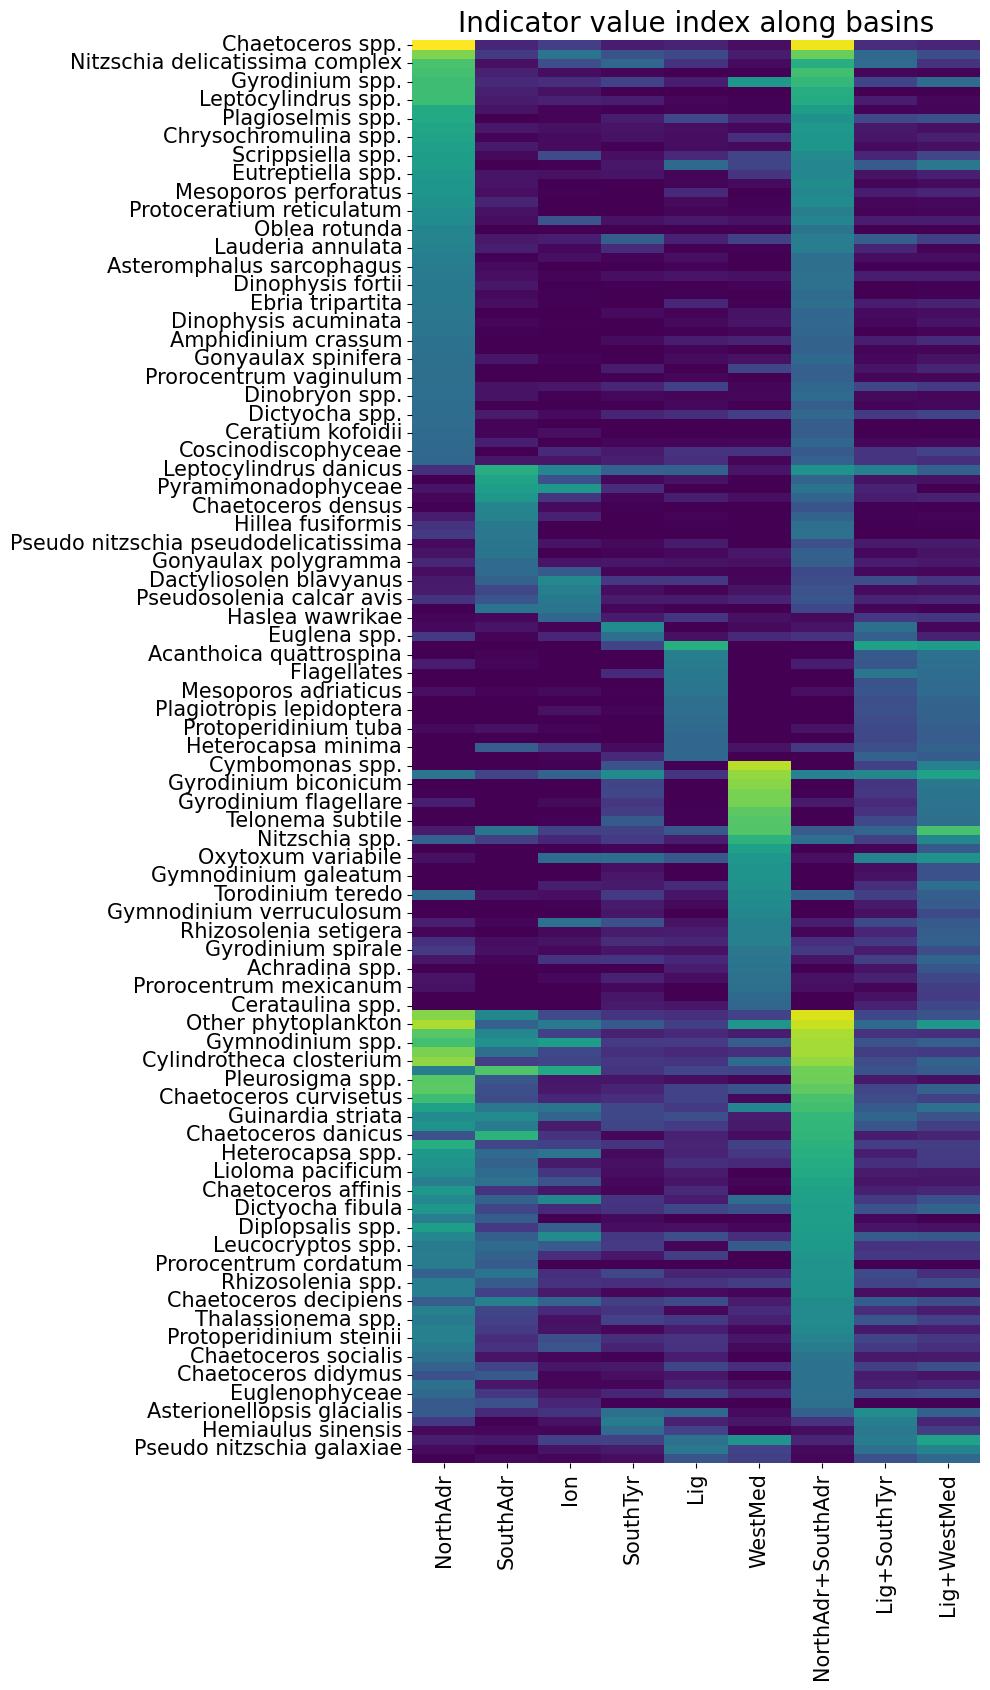

In [25]:
ordered_ids = order_species(IndVal, ["NorthAdr", "SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed", "NorthAdr+SouthAdr", "Lig+SouthTyr", "Lig+WestMed"])
indval_plot(
    IndVal.loc[ordered_ids, :], 
    title = "Indicator value index along basins", 
    file_name = _HOME_ + "/ISPRA_20152017_Analysis/Description/Taxa_indval_per_basin_w_comb.png"
    )

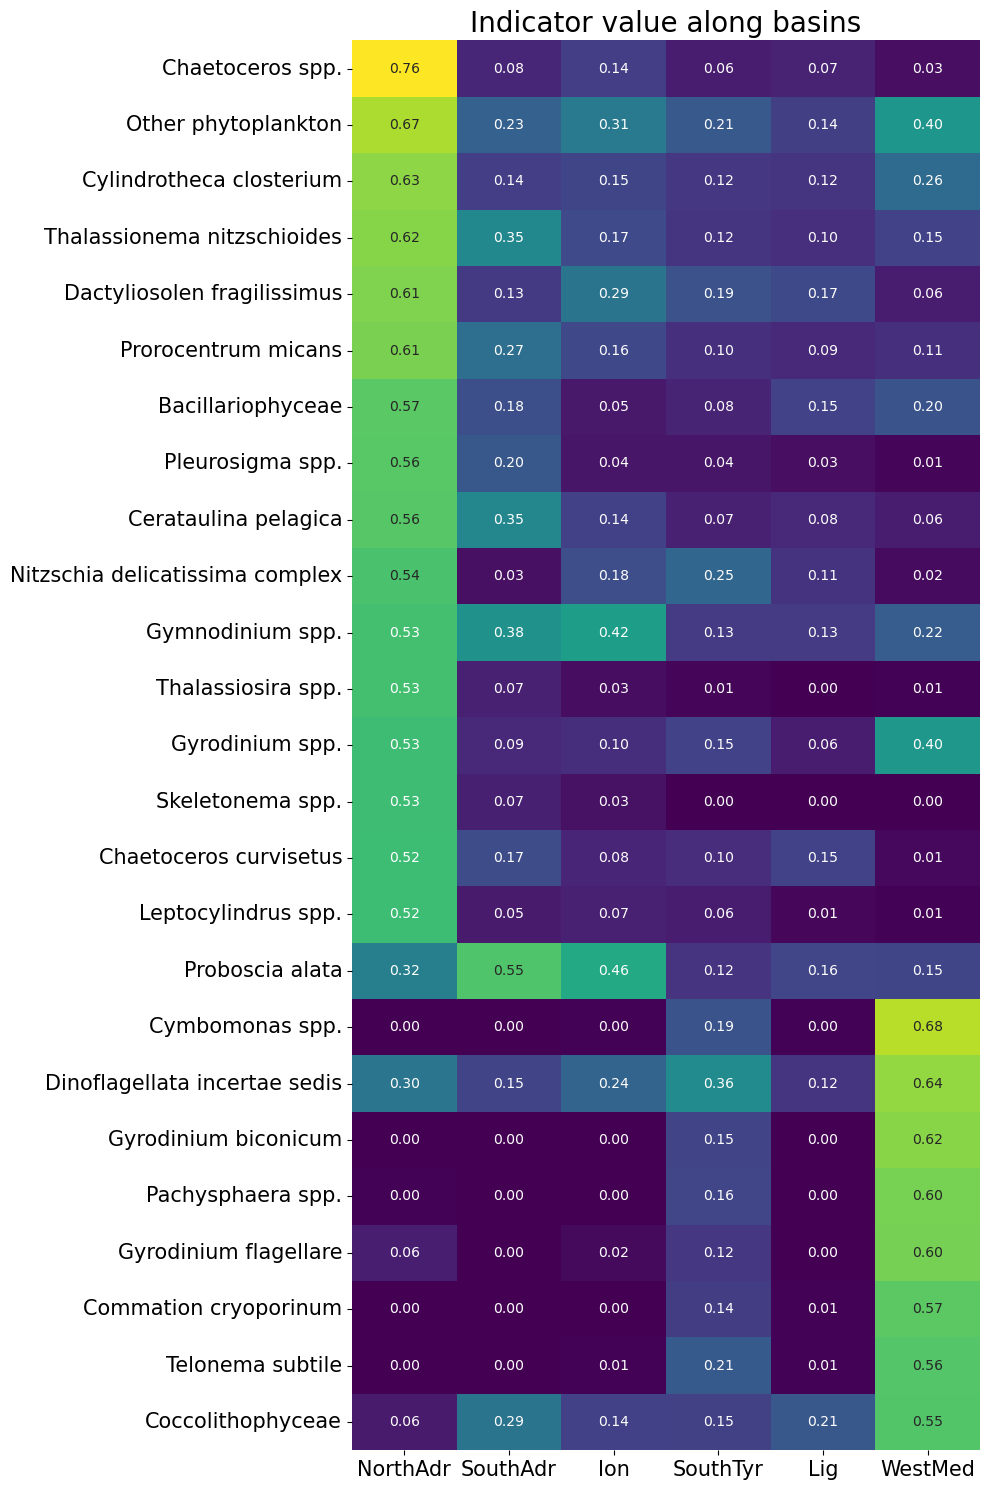

In [22]:
ordered_ids = order_species(IndVal, ["NorthAdr", "SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed"], 0.5)
indval_plot(
    IndVal.loc[ordered_ids, ["NorthAdr", "SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed"]], 
    title = "Indicator value along basins", 
    file_name = _HOME_ + "/ISPRA_20152017_Analysis/Description/Taxa_indval_per_basin.png", 
    figsize = (10, 15),
    annot = True,
    fmt=".2f"
    )

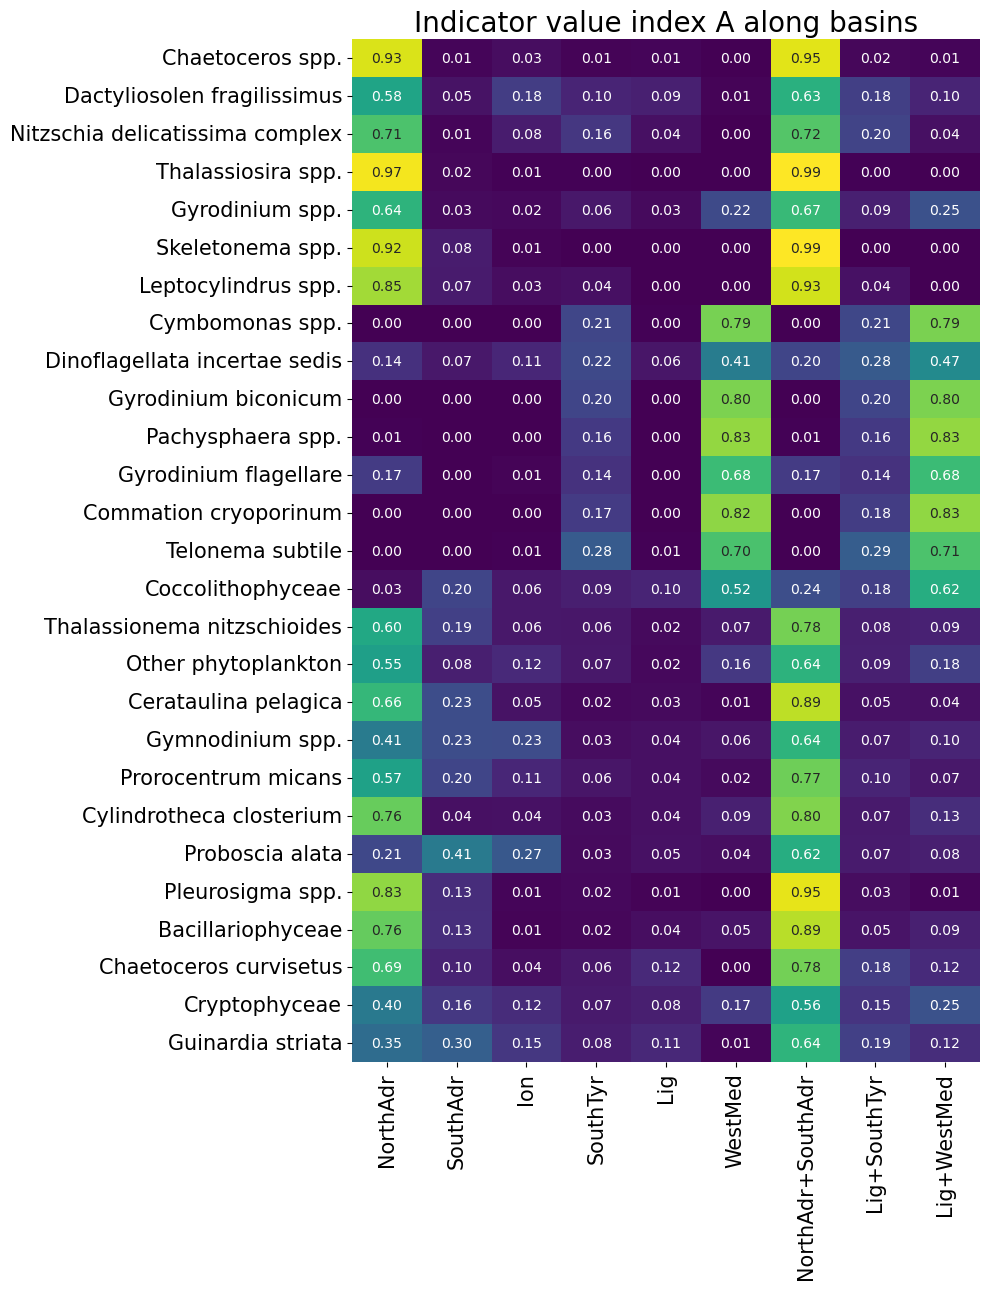

<Figure size 640x480 with 0 Axes>

In [57]:
ordered_ids = order_species(IndVal, ["NorthAdr", "SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed", "NorthAdr+SouthAdr", "Lig+SouthTyr", "Lig+WestMed"])
indval_plot(
    IndVal_A.loc[ordered_ids, :], 
    title = "Indicator value index A along basins", 
    file_name = _HOME_ + "/ISPRA_20152017_Analysis/Description/Taxa_indval_per_basin_A_w_comb.png"
    )

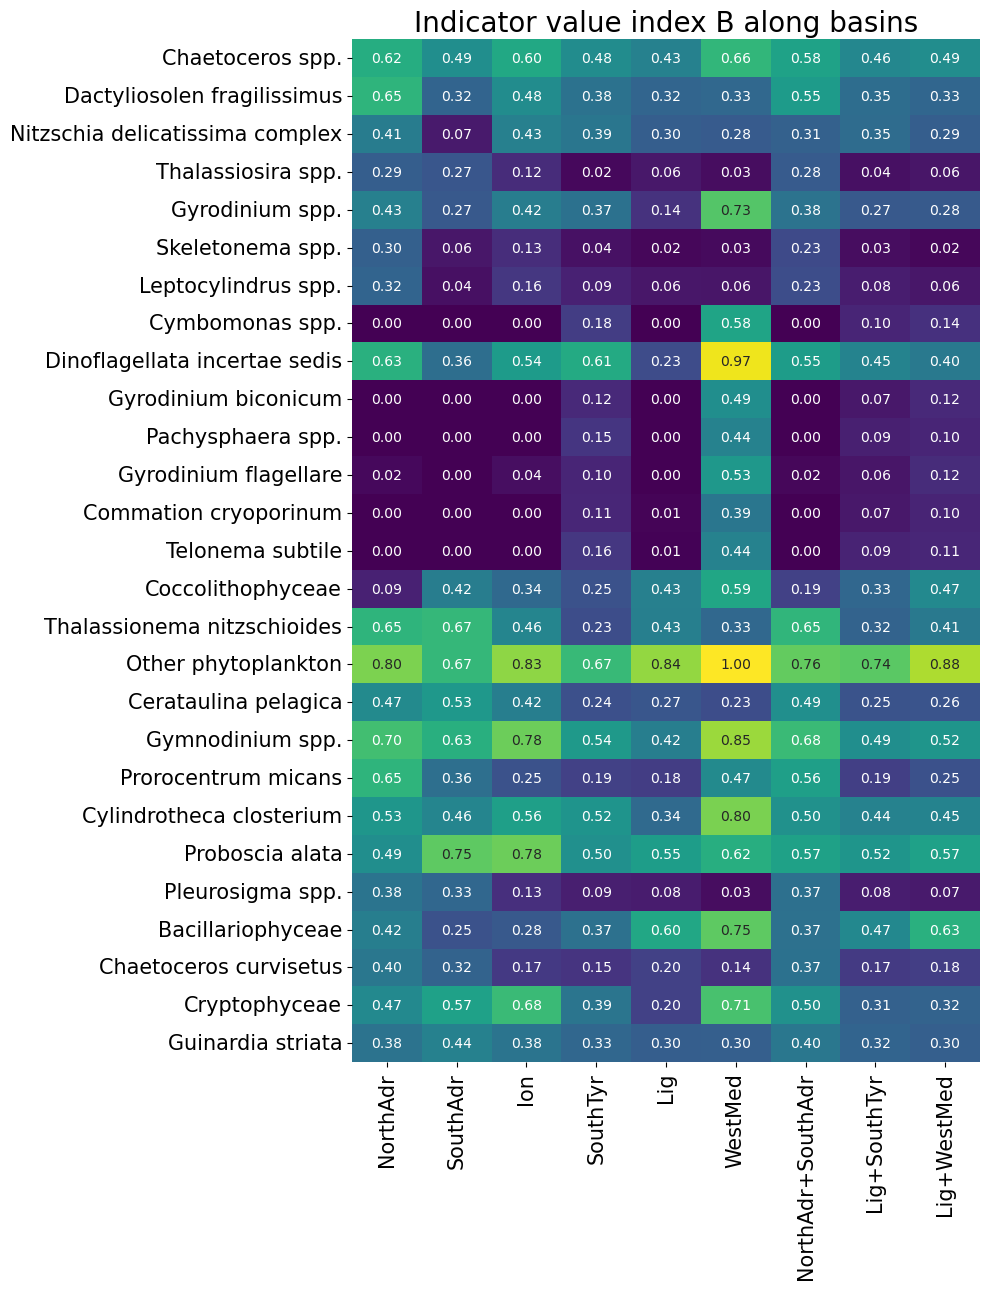

<Figure size 640x480 with 0 Axes>

In [59]:
ordered_ids = order_species(IndVal, ["NorthAdr", "SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed", "NorthAdr+SouthAdr", "Lig+SouthTyr", "Lig+WestMed"])
indval_plot(
    IndVal_B.loc[ordered_ids, :], 
    title = "Indicator value index B along basins", 
    file_name = _HOME_ + "/ISPRA_20152017_Analysis/Description/Taxa_indval_per_basin_B_w_comb.png"
    )

In [7]:
indval_dfs = pd.read_excel(_HOME_ + "/ISPRA_20152017_Analysis/Description/indval_per_basin_log_trasf.xlsx", sheet_name  = None, index_col = 0)

IndVal = indval_dfs["Indval"].loc[:, ["NorthAdr", "SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed", "NorthAdr+SouthAdr", "Lig+SouthTyr", "Lig+WestMed"]]
IndVal_A = indval_dfs["Indval_A"].loc[:, ["NorthAdr", "SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed", "NorthAdr+SouthAdr", "Lig+SouthTyr", "Lig+WestMed"]]
IndVal_B = indval_dfs["Indval_B"].loc[:, ["NorthAdr", "SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed", "NorthAdr+SouthAdr", "Lig+SouthTyr", "Lig+WestMed"]]

IndVal.index = list(map(lambda x: re.sub(r'\.(?!$)', ' ', x), IndVal.index))
IndVal.index.name = "Taxon"
IndVal_A.index = list(map(lambda x: re.sub(r'\.(?!$)', ' ', x), IndVal_A.index))
IndVal_A.index.name = "Taxon"
IndVal_B.index = list(map(lambda x: re.sub(r'\.(?!$)', ' ', x), IndVal_B.index))
IndVal_B.index.name = "Taxon"

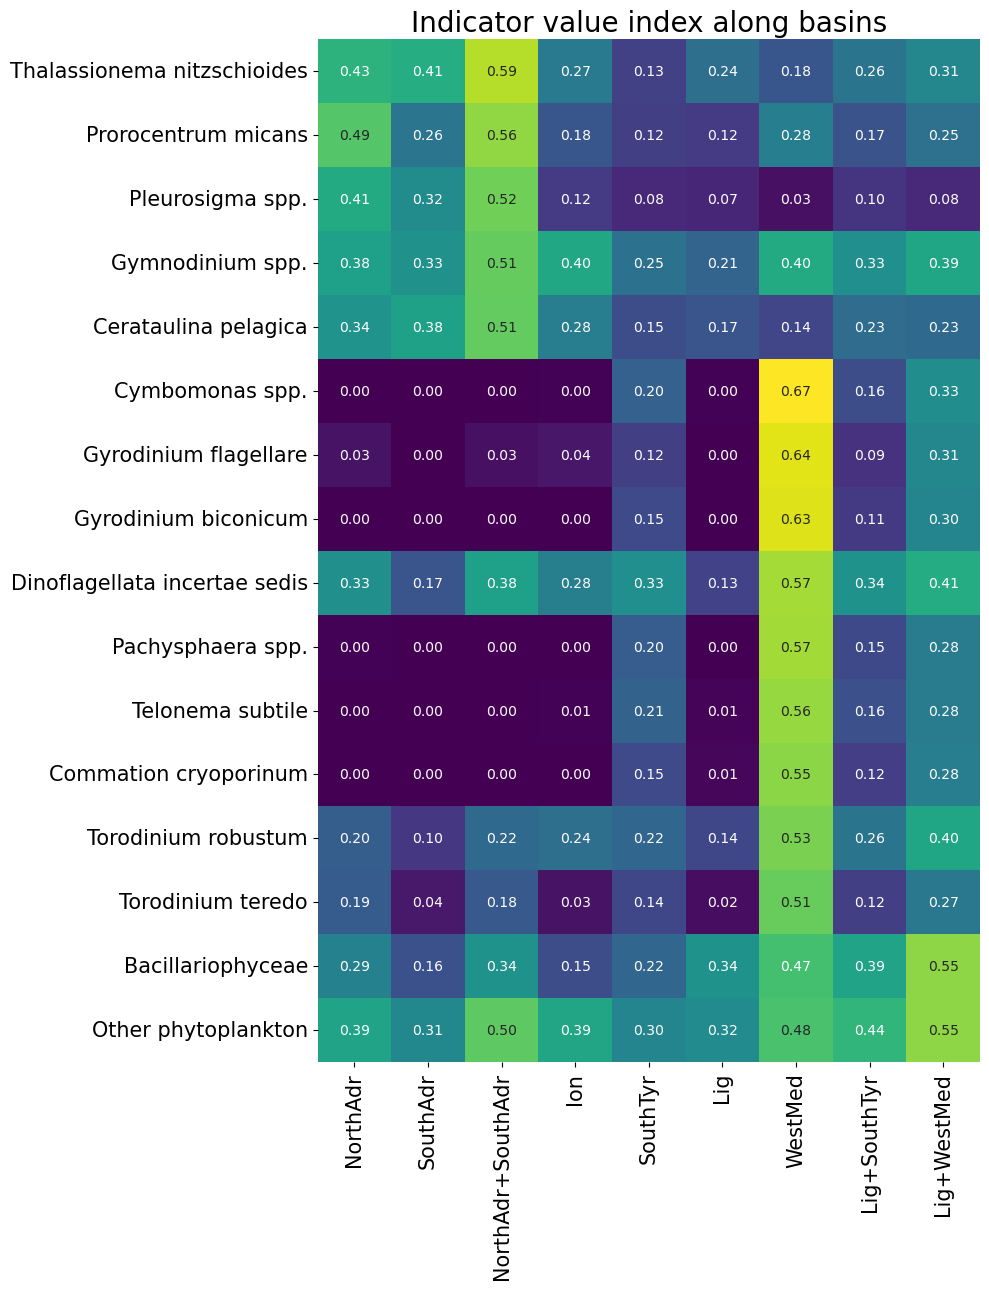

In [10]:
ordered_ids = order_species(IndVal, ["NorthAdr", "SouthAdr", "NorthAdr+SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed", "Lig+SouthTyr", "Lig+WestMed"])
indval_plot(
    IndVal.loc[ordered_ids, ["NorthAdr", "SouthAdr", "NorthAdr+SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed", "Lig+SouthTyr", "Lig+WestMed"]], 
    title = "Indicator value index along basins", 
    file_name = _HOME_ + "/ISPRA_20152017_Analysis/Description/Taxa_indval_per_basin_w_comb_log.png"
    )

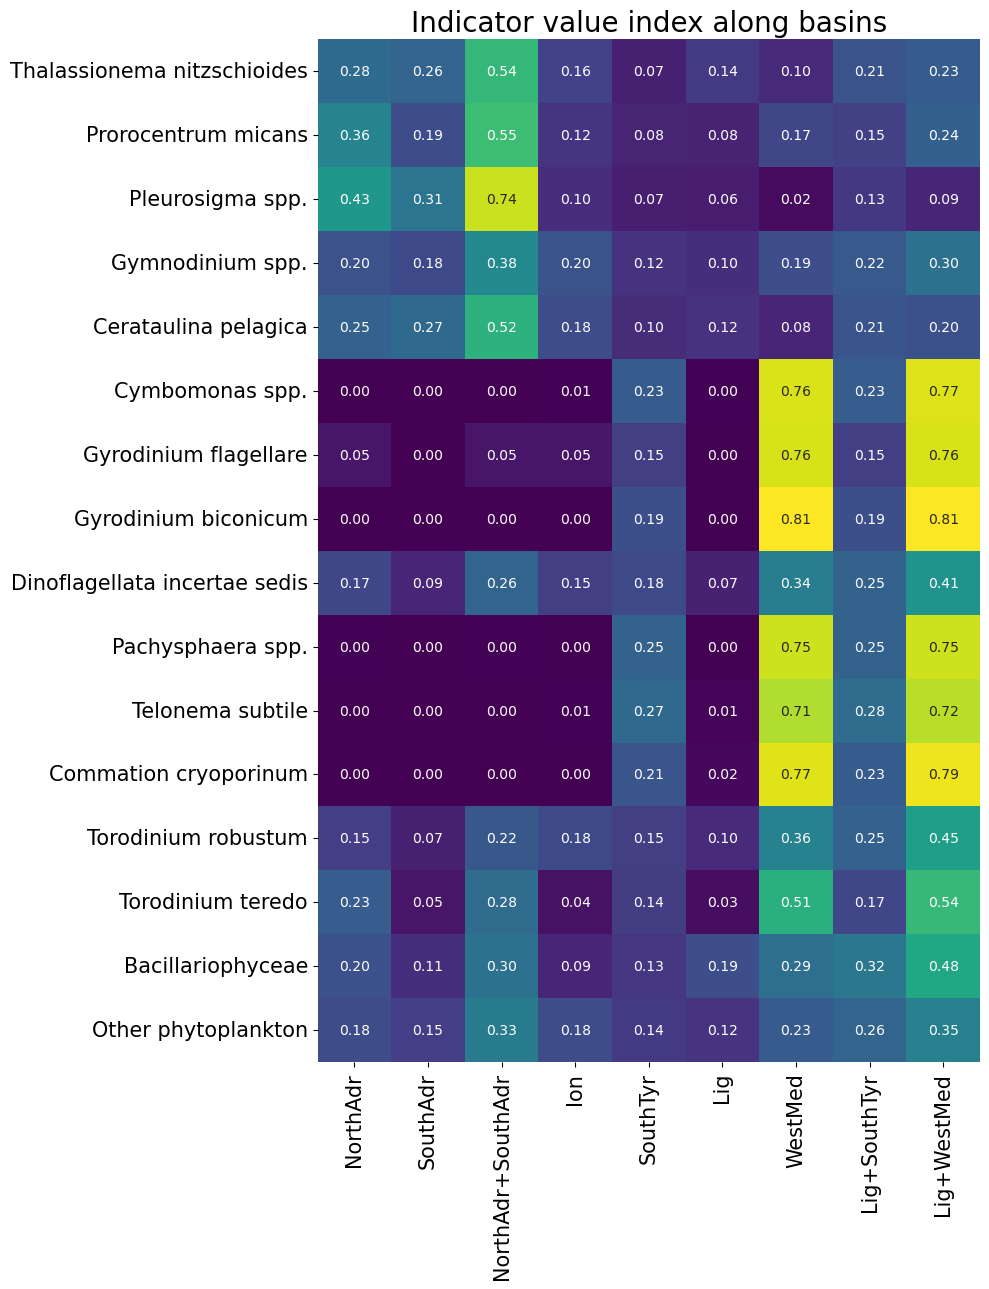

In [11]:
ordered_ids = order_species(IndVal, ["NorthAdr", "SouthAdr", "NorthAdr+SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed", "Lig+SouthTyr", "Lig+WestMed"])
indval_plot(
    IndVal_A.loc[ordered_ids, ["NorthAdr", "SouthAdr", "NorthAdr+SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed", "Lig+SouthTyr", "Lig+WestMed"]], 
    title = "Indicator value index along basins", 
    file_name = _HOME_ + "/ISPRA_20152017_Analysis/Description/Taxa_indval_A_per_basin_w_comb_log.png"
    )

In [94]:
mean_abund = phyto_abund_simplified.groupby(["Basin", "Taxon"], observed=True).mean(numeric_only=True)[["Num_cell_l"]].sort_values("Num_cell_l", ascending = False)

In [92]:
mean_abund.apply(lambda x: x / mean_abund.sum(), axis=1).head(20)

Num_cell_l
Taxon                                      
Skeletonema spp.                   0.254978
Skeletonema costatum               0.141262
Chaetoceros neglectus              0.105204
Chaetoceros socialis               0.091387
Other phytoplankton                0.045399
Chaetoceros spp.                   0.023102
Chaetoceros delicatulus            0.019471
Chaetoceros radicans               0.016403
Thalassiosira spp.                 0.015950
Chrysochromulina spp.              0.015648
Cyclotella spp.                    0.013596
Heterocapsa rotundata              0.013552
Plagioselmis spp.                  0.011448
Leptocylindrus convexus            0.008675
Cyclotella meneghiniana            0.008658
Cyclotella caspia                  0.008536
Cryptophyceae                      0.008425
Nitzschia delicatissima complex    0.007758
Chaetoceros compressus             0.007022
Cyclotella glomerata               0.006290

# Part 3

In [99]:
abund_basin = phyto_abund_simplified.groupby("Basin", observed=True).sum(numeric_only=True)[["Num_cell_l"]]

In [119]:
abund_taxon_basin = phyto_abund_simplified.groupby(["Basin", "Taxon"], observed=True).sum(numeric_only=True)[["Num_cell_l"]].sort_values("Num_cell_l")

In [122]:
top_abund_taxa_basin = abund_taxon_basin.div(abund_basin, axis=0).reset_index().sort_values(["Basin", "Num_cell_l"], ascending=[True, False]).groupby("Basin", observed=True, sort=False).head(5)

Text(0, 0.5, 'Relative abundance')

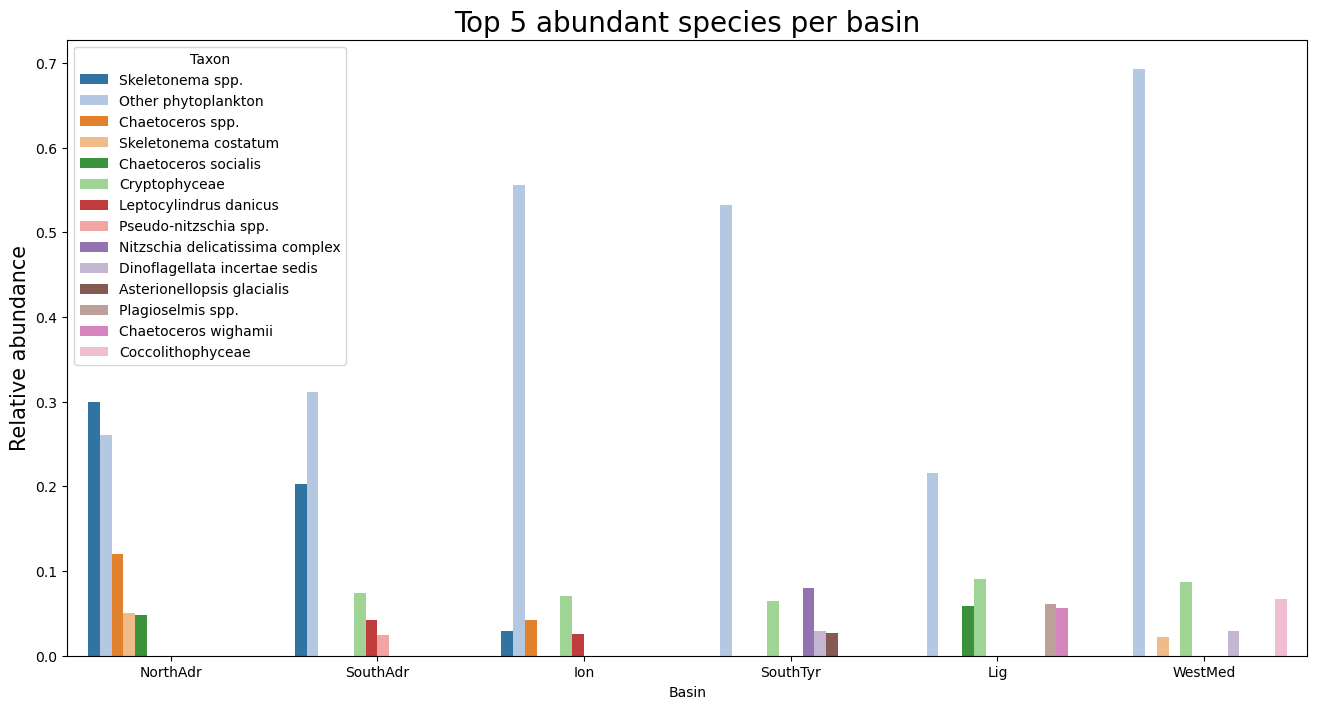

In [195]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(top_abund_taxa_basin, y = "Num_cell_l", x = "Basin", hue = "Taxon", ax = ax, 
            dodge = True, palette = plt.get_cmap('tab20').colors, 
            )
ax.set_title("Top 5 abundant taxa per basin", fontsize = 20)
ax.set_ylabel("Relative abundance", fontsize = 15)

In [202]:
abund_genus = phyto_abund_simplified.loc[:, ["Genus", "Taxon", "Num_cell_l", "Basin"]]

In [204]:
abund_genus.loc[abund_genus["Genus"].isna(), "Genus"] = abund_genus.loc[abund_genus["Genus"].isna(), "Taxon"]

In [205]:
abund_genus_basin = abund_genus.groupby(["Basin", "Genus"], observed=True).sum(numeric_only=True)[["Num_cell_l"]]

In [209]:
top_abund_genus_basin = abund_genus_basin.div(abund_basin, axis=0).reset_index().sort_values(["Basin", "Num_cell_l"], ascending=[True, False]).groupby("Basin", observed=True, sort=False).head(5)

Text(0, 0.5, 'Relative abundance')

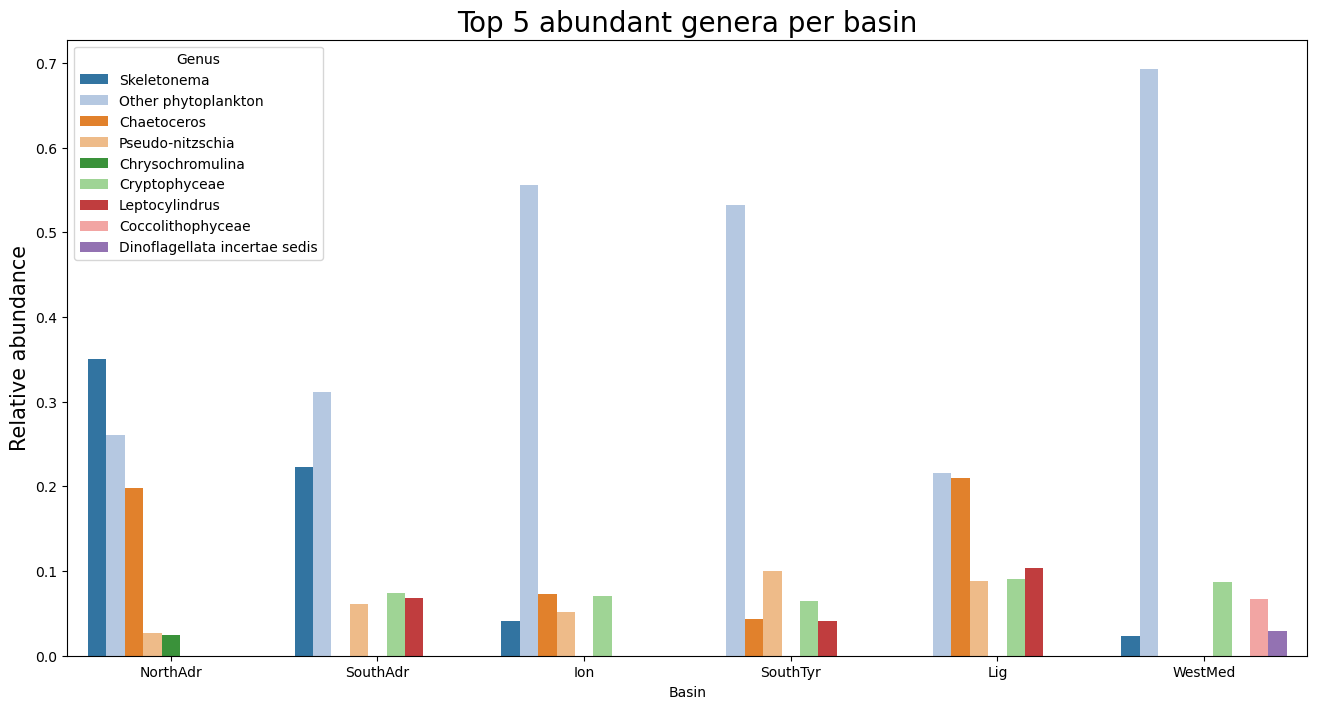

In [211]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(top_abund_genus_basin, y = "Num_cell_l", x = "Basin", hue = "Genus", ax = ax, 
            dodge = True, palette = plt.get_cmap('tab20').colors, 
            )
ax.set_title("Top 5 abundant genera per basin", fontsize = 20)
ax.set_ylabel("Relative abundance", fontsize = 15)

In [155]:
det_level = "Genus"
df = phyto_abund_simplified.loc[:, ["Taxon", det_level, "Class", "Num_cell_l", "Basin", "Season"]]
df.loc[df["Genus"].isna(), "Genus"] = df.loc[df[det_level].isna(), "Taxon"]
taxa_abund_season_basin = df.groupby(["Basin", "Season", det_level], observed=True).sum(numeric_only=True)[["Num_cell_l"]]

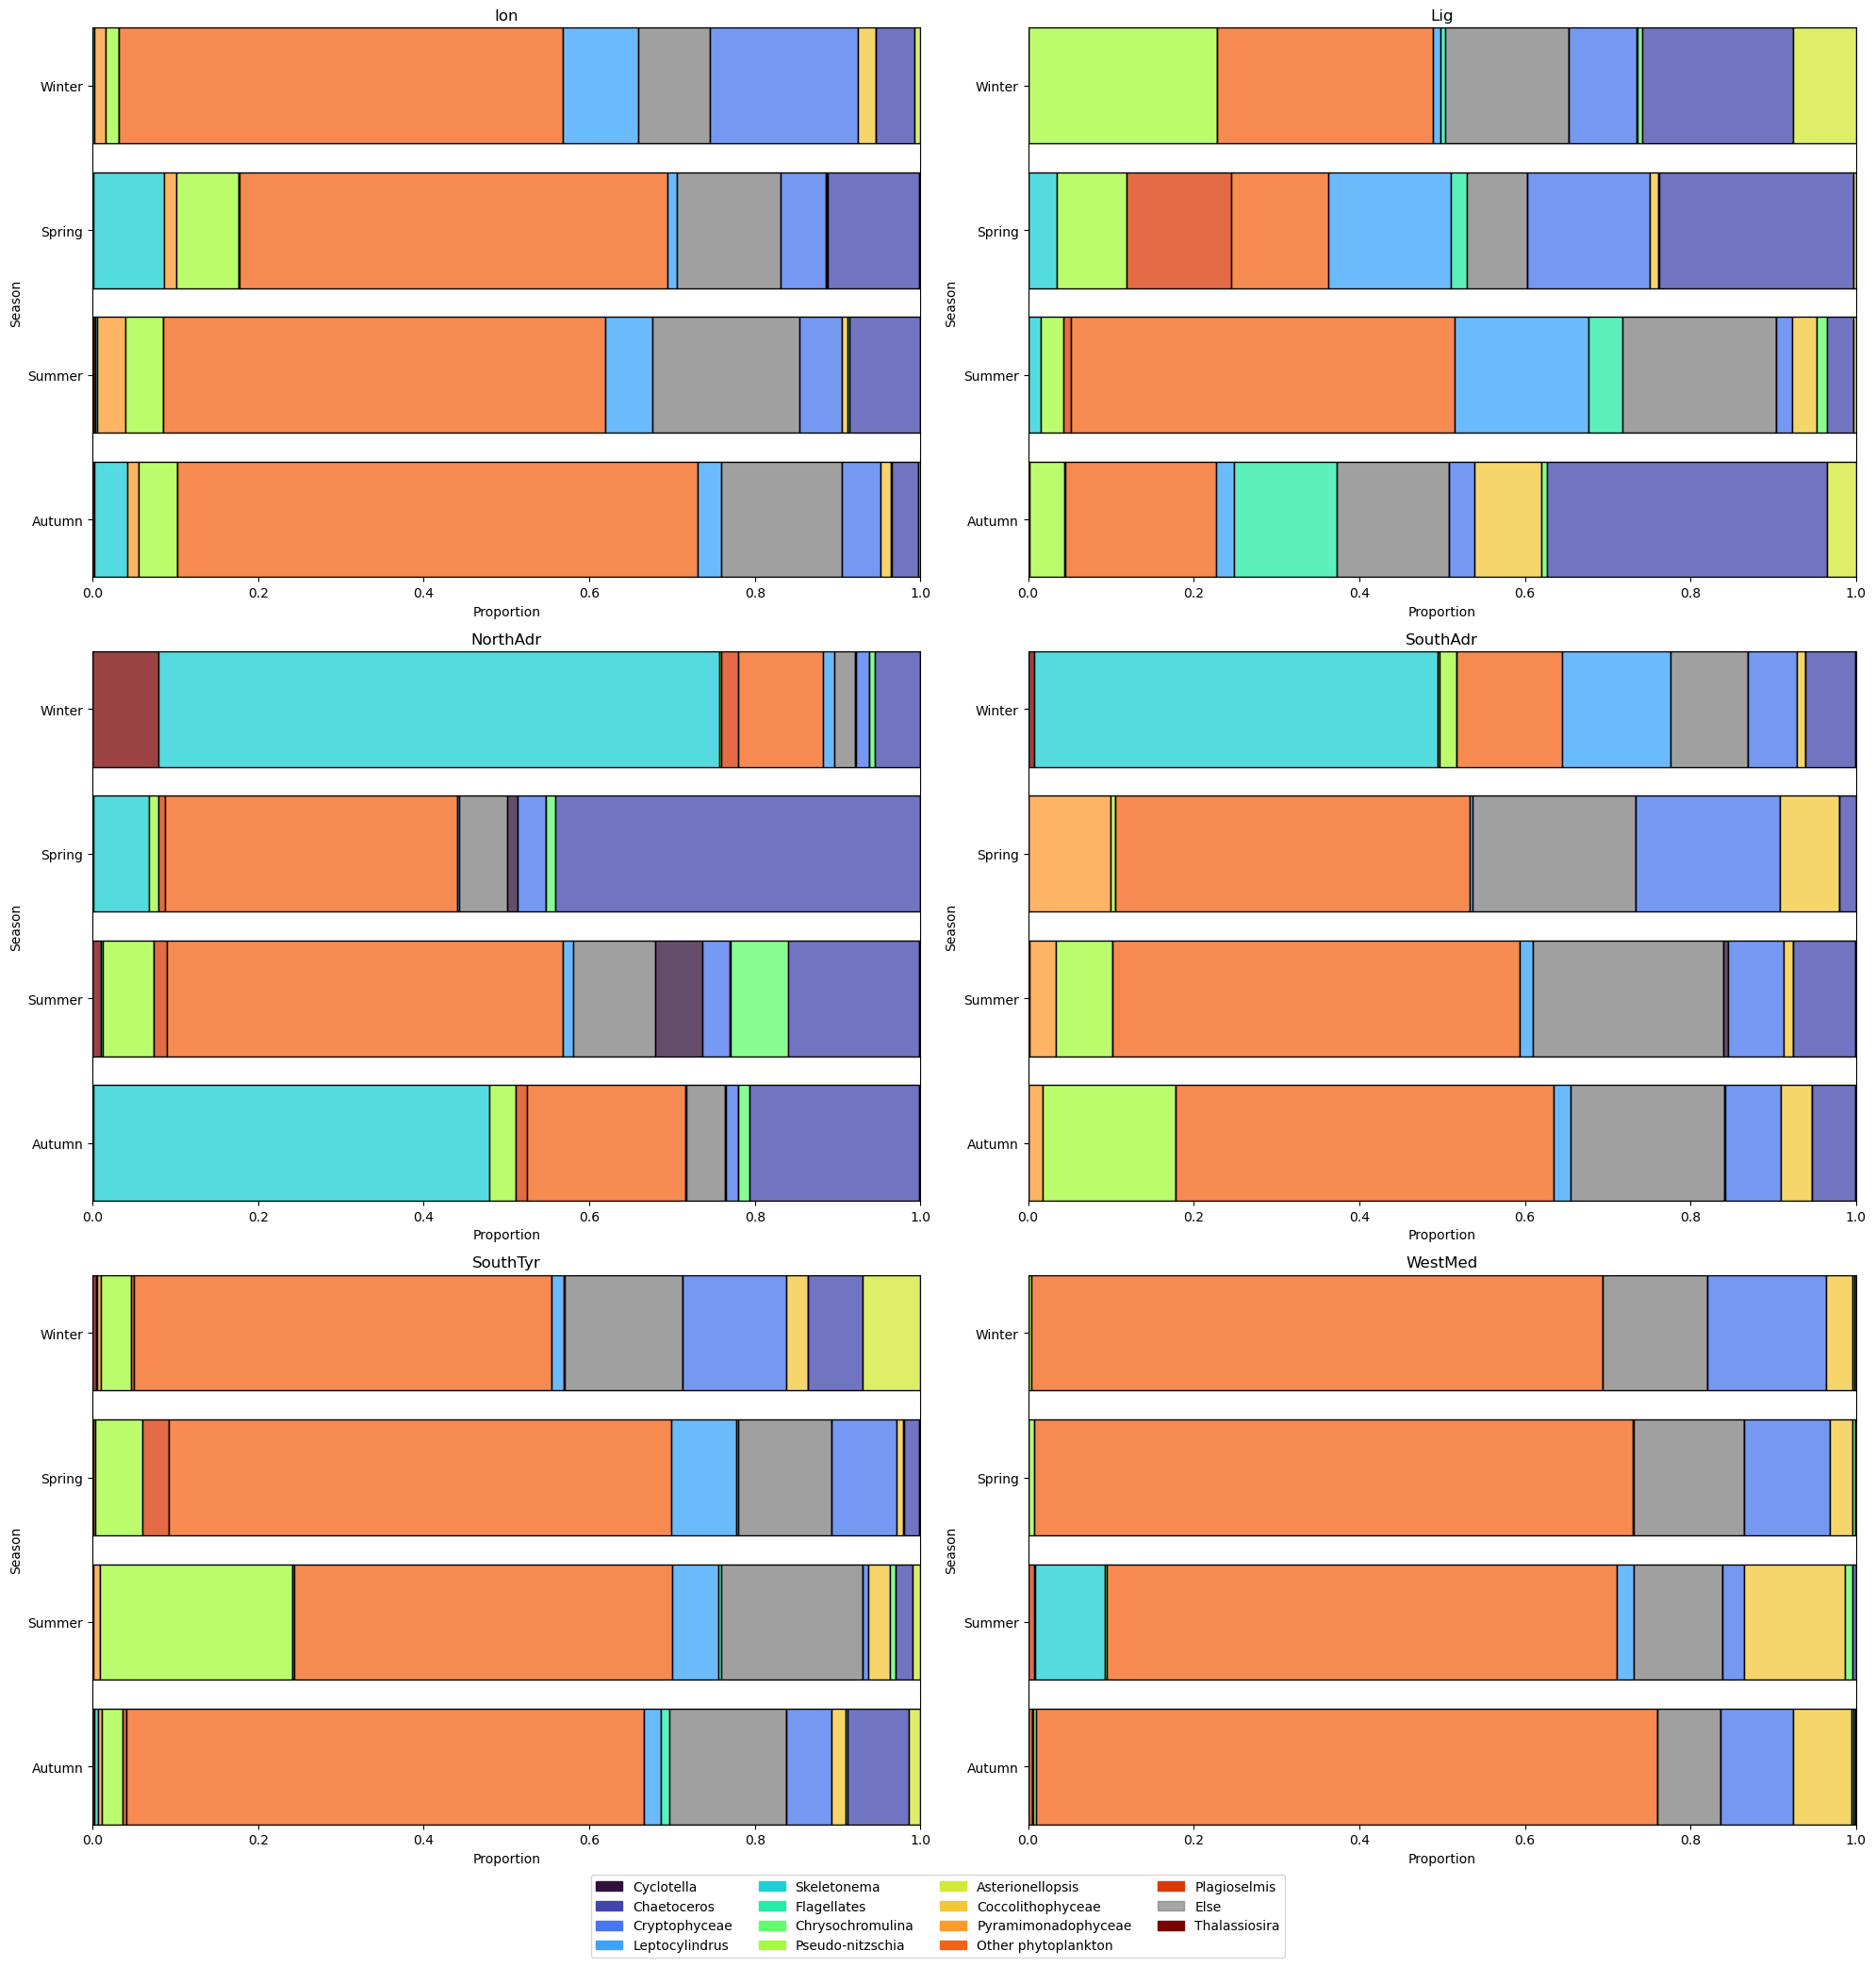

In [157]:

fig, axs = plt.subplots(3, 2, figsize=(20, 20))
axs = axs.ravel()
taxa_above_threshold = set()
for basin_name, df_basin in taxa_abund_season_basin.groupby("Basin", observed=True): 
    taxa_above_threshold = taxa_above_threshold.union(
    df_basin.div(df_basin.groupby(level = "Season", observed = True).sum(numeric_only=True)).query("Num_cell_l > 0.05").index.get_level_values(det_level).unique()
    )

taxa_above_threshold = taxa_above_threshold.union(["Else"])
num_colors = len(taxa_above_threshold)
colors = plt.get_cmap("turbo")(np.linspace(0, 1, num_colors))
color_dict = {name: color for name, color in zip(taxa_above_threshold, colors)}
color_dict["Bacillariophyceae"] = [123 / 255, 62 / 255, 228 / 255, 0.7]
color_dict["Else"] = [0.5, 0.5, 0.5, 0.7]

for ax, (basin_name, df_basin) in zip(axs, taxa_abund_season_basin.groupby("Basin", observed=True)): 
    df = df_basin.reset_index()
    df.loc[~df[det_level].isin(taxa_above_threshold), det_level] = "Else"

    sns.histplot(
        data=df.groupby(["Season", det_level], observed=True).sum(numeric_only=True),
        y="Season", hue=det_level, weights="Num_cell_l",
        multiple="fill", stat="proportion",
        palette = color_dict,
        discrete=True, shrink=.8, legend=False,
        ax = ax
    )
    ax.set_title(basin_name)

handles = [mpatches.Patch(color=color_dict[name], label=name) for name in taxa_above_threshold]
fig.legend(handles=handles, bbox_to_anchor=(0, -.07, 1, 0.101), loc='center', ncol=4)
plt.tight_layout()